<a href="https://colab.research.google.com/github/HenryZumaeta/MDS_UNI/blob/Zeta/CICLO02/MLSA/C04_20240517_implementation_income.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicción de Ingreso - MCD UNI
Manuel Valdivia

## Cargando Librerias y utilitarios

Aqui cargamos las librerias con las que vamos a trabajar, asi como ciertas funciones predeterminadas

In [35]:
# Instalamos librería para descargar datos desde drive
# !pip install gdown


In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns



In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [49]:
# Funcion para descargar data desde drive
import gdown
import os

def descargar_y_leer_archivo_desde_drive(enlace_original, nombre_archivo='archivo.csv'):
    """
    Convierte un enlace de Google Drive a un enlace de descarga directa,
    descarga el archivo y lo lee como un DataFrame de pandas.

    Parámetros:
    enlace_original (str): Enlace de Google Drive en formato de vista previa.
    nombre_archivo (str): Nombre del archivo de salida.

    Retorna:
    DataFrame: El contenido del archivo leído como un DataFrame de pandas.
    """
    def convertir_enlace_gdown(enlace_original):
        file_id = enlace_original.split('/')[5]
        return f'https://drive.google.com/uc?id={file_id}'

    url = convertir_enlace_gdown(enlace_original)

    try:
        gdown.download(url, nombre_archivo, quiet=False)
        if not os.path.exists(nombre_archivo):
            raise FileNotFoundError("No se pudo descargar el archivo. Puede que no sea accesible.")
    except Exception as e:
        print(f"Error: {e}")
        print("Por favor, verifica los permisos del archivo o usa otro método de compartición.")
        return None
    else:
        return pd.read_csv(nombre_archivo)


replacenullentero: Reemplaza valores nulos de las variables de tipo numérico.
- Aleatoriamente reemplaza los valores nulos por valores reales.

In [3]:
import random

def replacenullentero(df,entero):
  df1=df[df[entero].isnull()]
  df2=df[~df[entero].isnull()]
  df3=df1.reset_index()
  df3=df3.rename(columns = {'index':'index_2'})
  df3=df3.reset_index()
  index_nullint=list(range(df3.shape[0]))
  random.shuffle(index_nullint)
  ingreso=list(df2[entero].sample(df3.shape[0]))
  df4=pd.DataFrame({"index":index_nullint,entero:ingreso})
  df3[entero] = np.where(df3[entero].isnull(),df3['index'].map(df4.set_index('index')[entero]),df3[entero])
  df3=df3.drop("index",axis=1)
  df3=df3.rename(columns = {'index_2':'index'})
  dft=df.reset_index()
  dft[entero] = np.where(dft[entero].isnull(),dft['index'].map(df3.set_index('index')[entero]),dft[entero])
  dft=dft.set_index("index")
  return dft

replacenullstring: Reemplaza valores nulos de las variables de tipo string.
- Calcula los porcentajes de las categorias de la variable y reemplaza aleatoriamente los valores nulos por valores reales.

In [4]:
import itertools
import random

def replacenullstring(df,string):
  df["VALOR"]=1
  df1=df.groupby(string)["VALOR"].count().reset_index().sort_values("VALOR",ascending=False).reset_index()
  df1=df1[df1[string]!="nan"].reset_index().drop("index", axis=1)
  df1["porcentaje"]=df1["VALOR"].apply(lambda x: x/df1["VALOR"].sum())
  df2=df[(df[string].isnull()) | (df[string]=="nan")]
  df1["numerodereemplazos"]=df1["porcentaje"].apply(lambda x: int(round(x*df2.shape[0],0)))
  df1.loc[df1.shape[0]-1, "numerodereemplazos"]=df2.shape[0]-df1.loc[:df1.shape[0]-2,"numerodereemplazos"].sum()
  k=1
  valor_nullstring = []
  if k<=df1.shape[0]:
    for i in df1["numerodereemplazos"]:
      valor=[k]*i
      valor=[df1[string].loc[k-1] if item == k else item for item in valor]
      valor_nullstring.append(valor)
      k=k+1
  valor_nullstring = list(itertools.chain(*valor_nullstring))
  df3=df2.reset_index()
  df3=df3.rename(columns = {'index':'index_2'})
  df3=df3.reset_index()
  index_nullstring=list(range(df3.shape[0]))
  random.shuffle(index_nullstring)
  df4=pd.DataFrame({"index":index_nullstring,string:valor_nullstring})
  df3[string] = np.where((df3[string].isnull()) | (df3[string]=="nan"),df3['index'].map(df4.set_index('index')[string]),df3[string])
  df3=df3.drop("index",axis=1)
  df3=df3.rename(columns = {'index_2':'index'})
  dft=df.reset_index()
  dft[string] = np.where((dft[string].isnull()) | (dft[string]=="nan"),dft['index'].map(df3.set_index('index')[string]),dft[string])
  dft=dft.set_index("index")
  dft=dft.drop("VALOR",axis=1)
  return dft

tabla_pivot1: Convierte las categorias de la variable en columnas, es decir aplica pivot a las variables.

In [5]:
def tabla_pivot1(df,campo1,campo2):
  try:
    ### pivot del df
    df_pivot = df.pivot_table(index=['codmes','id_persona'], columns=[campo1], values=[campo2], aggfunc=np.sum)

    ### limpiando las columnas
    df_pivot.columns = [first + '_' + str(second) for first,second in df_pivot.columns]
    df_pivot.columns = df_pivot.columns.str.lower()
    df_pivot.columns = [col.replace(' ','') for col in df_pivot.columns]
    df_pivot = df_pivot.reset_index()

    if campo1 == 'cod_banco':
      df_pivot[campo2+'_total'] = df_pivot[df_pivot.columns[2:]].sum(axis=1)
  except:
    ### pivot del df
    df_pivot = df.pivot_table(index=['id_persona'], columns=[campo1], values=[campo2], aggfunc=np.sum)

    ### limpiando las columnas
    df_pivot.columns = [first + '_' + str(second) for first,second in df_pivot.columns]
    df_pivot.columns = df_pivot.columns.str.lower()
    df_pivot.columns = [col.replace(' ','') for col in df_pivot.columns]
    df_pivot = df_pivot.reset_index()
  return df_pivot

tabla_pivot2: Calcula nuevas variables como promedios, frecuencias, incrementos, varianza.

In [6]:
def tabla_pivot2(df, inicio, final, lag):
  ### ordenando el df
  df = df.sort_values(['codmes','id_persona'],ascending=[True,True])
  df = df[(df["codmes"]>=inicio) & (df["codmes"]<=final)]
  df1 = df[['codmes','id_persona']]

  for columna in df.columns[2:]:
    df_prev = df[['codmes','id_persona',columna]]
    df_prev.columns = ["codmes", "id_persona", columna + "_" + str(1)]

    ### generando los n meses anteriores
    for i in range(1,lag+1):
      df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)

    ### Promedio de los ultimos n meses
    for value in [3,6,9,12]:
      if value <= lag:
        df_prev[columna+"_prom_"+str(value)+"m"] = df_prev[df_prev.columns[2:(value+2)]].mean(axis = 1)
      else:
        pass
    df_prev = df_prev.fillna(0)

    ### Tenencia de saldo
    for i in range(1,lag+1):
      if len(columna.split('_')) <= 2:
        campo = 'flg_'+columna.split('_')[0]+'_'+columna.split('_')[1]
      else:
        campo = 'flg_'+columna.split('_')[0]+'_'+columna.split('_')[1]+'_'+columna.split('_')[2]
      df_prev[campo+"_"+str(i)] = df_prev[columna+'_'+str(i)].apply(lambda x : 1 if x > 0 else 0)

    ### Frecuencia de los ultimos n meses
    for value in [3,6,9,12]:
      if value <= lag:
        df_prev[columna+"_freq_"+str(value)+"m"] = df_prev[df_prev.columns[lag+7:(lag+7+value)]].sum(axis=1)
      else:
        pass

    ### Incremento de los ultimos n meses
    for value in [3,6,9,12]:
      if value <= lag:
        df_prev.loc[df_prev[columna+"_"+str(value)] != 0,columna+"_increm_"+str(value)+"m"] = (df_prev[columna+'_1'] - df_prev[columna+"_"+str(value)])/df_prev[columna+"_"+str(value)]
        df_prev.loc[(df_prev[columna+"_"+str(value)] == 0) & (df_prev[columna+'_1'] != 0),columna+"_increm_"+str(value)+"m"] = 1
        df_prev.loc[(df_prev[columna+"_"+str(value)] == 0) & (df_prev[columna+'_1'] == 0),columna+"_increm_"+str(value)+"m"] = 0
      else:
        pass

    ### Varianza de los ultimos n meses
    for value in [3,6,9,12]:
      if value <= lag:
        df_prev[columna+"_desv_"+str(value)+"m"] = df_prev[df_prev.columns[3:(value+3)]].std(axis = 1)
      else:
        pass

  ### Columnas finales
    columnas = list(df_prev.columns[0:2].append(df_prev.columns[2:lag+2]).append(df_prev.columns[lag+3:lag+7]).append(df_prev.columns[lag+19:]))

    if len(columna.split('_')) <= 1:
      df1 = df1.merge(df_prev[['codmes', 'id_persona', campo1, campo5]], how='left', on=['codmes','id_persona'])
    else:
      df1 = df1.merge(df_prev[columnas], how='left', on=['codmes','id_persona'])

  ### Calculando el mes de ejecución
  df1 = df1[df1["codmes"]==final]
  df1["year"] = df1["codmes"].astype(str).str[:4]
  df1["month"] = df1["codmes"].astype(str).str[4:]
  df1["day"] = "01"
  df1["date"] = pd.to_datetime(df1[['month','day','year']]) + pd.DateOffset(months=1)
  df1["year"] = df1["date"].dt.year.astype(str)
  df1["month"] = df1["date"].dt.month
  df1["month"] = df1["month"].apply(lambda x: "0"+str(x) if x<10 else str(x))
  df1["month"] = df1["month"].astype(str)
  df1["date_"] = df1["year"] + df1["month"]
  df1 = df1.fillna(0).drop(["year", "month", "day", "date", "codmes"], axis=1).rename(columns={"date_": "codmes"})
  df1["codmes"] = df1["codmes"].astype(int)
  return df1

## Informacion RCC

RCC contiene la información de la deuda de las personas en el sistema financiero. Asimismo, generaremos variables relacionadas a la deuda en el sistema financiero variables como promedios, frecuencias, incrementos, variabilidad, etc. Consideraremos la deuda a nivel bancos, productos, etc.

from google.colab import drive
drive.mount('/content/drive')

### Cargando los datos

Cargaremos la tabla RCC. Esta fuente contiene información acerca de la deuda de las personas a nivel banco, a nivel producto, clasificación riesgos, tipo de crédito, calificación deudor. Asimismo, la información data de los meses desde marzo 2017 hasta febrero 2018.

In [ ]:
### Cuando queremos cargar los datos y tener el formato especifico de cada columna, es decir formato: numérico, string, date

# from collections import defaultdict
# dtypes = defaultdict(lambda: int)
# dtypes["index_column"] = str
# dtypes["other_special_column"] = object

# from datetime import datetime
# dateparse = lambda x: datetime.strptime(x, "%d/%m/%Y").strftime("%Y-%m-%d")

In [ ]:
# SI ESTAMOS EN LOCAL:

# ruta ='C:/Users/avaldiviac/Desktop/Clase STC/laboratorio 2 nuevo/'

### cargamos los datos RCC
# df = pd.read_csv('ib_base_rcc.csv', sep=",")

In [51]:
# SI ESTAMOS EN COLAB:

### cargamos los datos RCC
enlace_original = 'https://drive.google.com/file/d/1A9IG5k3f3s97g-2QNPxPdtfrmbp4TM3R/view?usp=sharing'
df = descargar_y_leer_archivo_desde_drive(enlace_original,"rcc.csv")

Downloading...
From (original): https://drive.google.com/uc?id=1A9IG5k3f3s97g-2QNPxPdtfrmbp4TM3R
From (redirected): https://drive.google.com/uc?id=1A9IG5k3f3s97g-2QNPxPdtfrmbp4TM3R&confirm=t&uuid=9a9c20a6-85b4-468e-a8af-41fcb48bc3b6
To: /content/rcc.csv
100%|██████████| 571M/571M [00:05<00:00, 96.8MB/s]


In [52]:
print("El numero de filas del dataframe es: ",df.shape[0])

El numero de filas del dataframe es:  11705553


In [53]:
### Primeros 5 lineas del dataframe
df.head(5)

codmes  id_persona  cod_banco               producto  clasif   mto_saldo  \
0  201811       10155         29  PRESTAMOS COMERCIALES     0.0  36698.4870   
1  201804       75442         29      PRESTAMO PERSONAL     0.0   7971.1182   
2  201902      172772         29  PRESTAMOS COMERCIALES     0.0    821.6077   
3  201810      187572         29  PRESTAMOS COMERCIALES     0.0   9271.8030   
4  201903      255598         29  PRESTAMOS COMERCIALES     0.0  10548.7263   

   rango_mora  
0         1.0  
1         1.0  
2         1.0  
3         1.0  
4         1.0

In [10]:
### Cantidad de registros por mes
df.groupby("codmes")["id_persona"].count()

codmes
201712    208666
201801    333740
201802    464216
201803    600387
201804    717448
201805    823523
201806    925919
201807    929008
201808    943442
201809    956031
201810    967670
201811    978395
201812    872058
201901    764782
201902    674476
201903    545792
Name: id_persona, dtype: int64

In [11]:
### Vamos a generar una muestra RCC

### seleccionamos el total de personas en RCC
df_personas = df["id_persona"].reset_index().drop("index", axis=1).drop_duplicates()

### definimos la cantidad de muestra (20%)
cantidad_muestra = int(df_personas.shape[0]*0.20)

### seleccionamos aleatoriamente las personas
df_muestra = df_personas.sample(cantidad_muestra, random_state=4242)["id_persona"].values

### Filtramos esa muestra de personas desde el dataframe total
df = df[df["id_persona"].isin(df_muestra)] ### 2341206

In [12]:
print("Cantidad de filas del dataframe de muestra: ", df.shape[0])

Cantidad de filas del dataframe de muestra:  2341206


In [13]:
### Formato de las columnas del dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2341206 entries, 1 to 11705552
Data columns (total 7 columns):
 #   Column      Dtype  
---  ------      -----  
 0   codmes      int64  
 1   id_persona  int64  
 2   cod_banco   int64  
 3   producto    object 
 4   clasif      float64
 5   mto_saldo   float64
 6   rango_mora  float64
dtypes: float64(3), int64(3), object(1)
memory usage: 142.9+ MB


### Exploración de los datos

Revisaremos el dataframe,  estadisticas descriptivas de los datos, valores nulos, valores duplicados, visualización de los datos, etc.

In [14]:
### Cambiando el formato de las variables desde int a string
df["cod_banco"] = df["cod_banco"].astype(str)
df["clasif"] = df["clasif"].astype(str)
df["rango_mora"] = df["rango_mora"].astype(str)

### Transformación de la variable saldo - Aplicaremoa transformación Logaritmica
df["mto_saldo"] = np.log(df["mto_saldo"])

In [15]:
### Estadisticas descriptivas de las variables de tipo int
df.drop(["codmes", "id_persona"], axis=1).describe().transpose()

count      mean       std       min       25%       50%  \
mto_saldo  2341206.0  7.421505  1.894167 -4.919881  6.398573  7.485362   

                75%        max  
mto_saldo  8.672486  15.053913

In [16]:
### Estadisticas descriptivas de las variables de tipo string
columnas = df.select_dtypes(include=[object]).columns

for value in columnas:
  print("Variable: ", value)
  print(df.groupby(value)["codmes"].count().reset_index(name='cantidad').sort_values("cantidad", ascending = False))
  print("-------------------------------------------------------------")

Variable:  cod_banco
   cod_banco  cantidad
30        40    415436
5         16    317571
54        66    232273
9         20    225840
16        28    206074
25        36    175905
58         7    148406
32        43    142682
42        52     99956
3         14     52692
19        30     45290
6         17     38750
63        75     33969
17        29     22556
51        62     21786
7         18     21209
50        60     16867
13        24     16613
33        44     12779
11        22     11888
8          2     10562
18         3      8477
65        77      8148
37        48      5635
38        49      4560
28        39      4340
68         8      4266
52        64      3859
29         4      3159
44        54      3012
0         10      2741
36        47      2332
35        46      2088
49        59      2028
43        53      2001
56        68      1858
39         5      1846
55        67      1614
57        69      1413
60        71      1095
27        38      1035
22        33 

### Revisión de datos nulos
df.isna().sum()

In [17]:
### Imputación de valores nulos - utilizamos la función replacenullstring
df = replacenullstring(df, "clasif")
df = replacenullstring(df, "rango_mora")

In [18]:
df.head(2)

codmes  id_persona cod_banco           producto clasif  mto_saldo  \
index                                                                      
1      201804       75442        29  PRESTAMO PERSONAL    0.0   8.983580   
17     201808       18885        29  PRESTAMO PERSONAL    0.0   8.054801   

      rango_mora  
index             
1            1.0  
17           1.0

<ipython-input-19-57826c67eeca>:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[f], color='b')


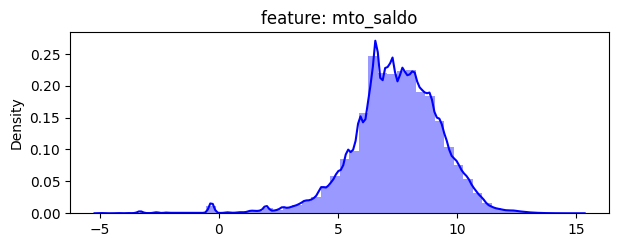

In [19]:
### visualizacion variables de tipo int

### Definiendo variables a graficar
features = df.drop(["codmes","id_persona"], axis=1).select_dtypes(exclude=[object])

### configuración de area de las gráficas
plt.figure(figsize=(32,32))
gs = gridspec.GridSpec(8, 4)
gs.update(hspace=0.8)

### Graficando las variables
for i, f in enumerate(features):
    ax = plt.subplot(gs[i])
    sns.distplot(df[f], color='b')
    ax.set_xlabel('')
    ax.set_title('feature: ' + str(f))

plt.show()

In [20]:
features.head(5)

mto_saldo
index           
1       8.983580
17      8.054801
18      8.384804
23      8.046006
25      8.386002

In [21]:
df.head(3)

codmes  id_persona cod_banco               producto clasif  mto_saldo  \
index                                                                          
1      201804       75442        29      PRESTAMO PERSONAL    0.0   8.983580   
17     201808       18885        29      PRESTAMO PERSONAL    0.0   8.054801   
18     201805       43298        29  PRESTAMOS COMERCIALES    0.0   8.384804   

      rango_mora  
index             
1            1.0  
17           1.0  
18           1.0

<ipython-input-22-e8bcbb5ee7b2>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
<ipython-input-22-e8bcbb5ee7b2>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
<ipython-input-22-e8bcbb5ee7b2>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
<ipython-input-22-e8bcbb5ee7b2>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(),rotation=90)


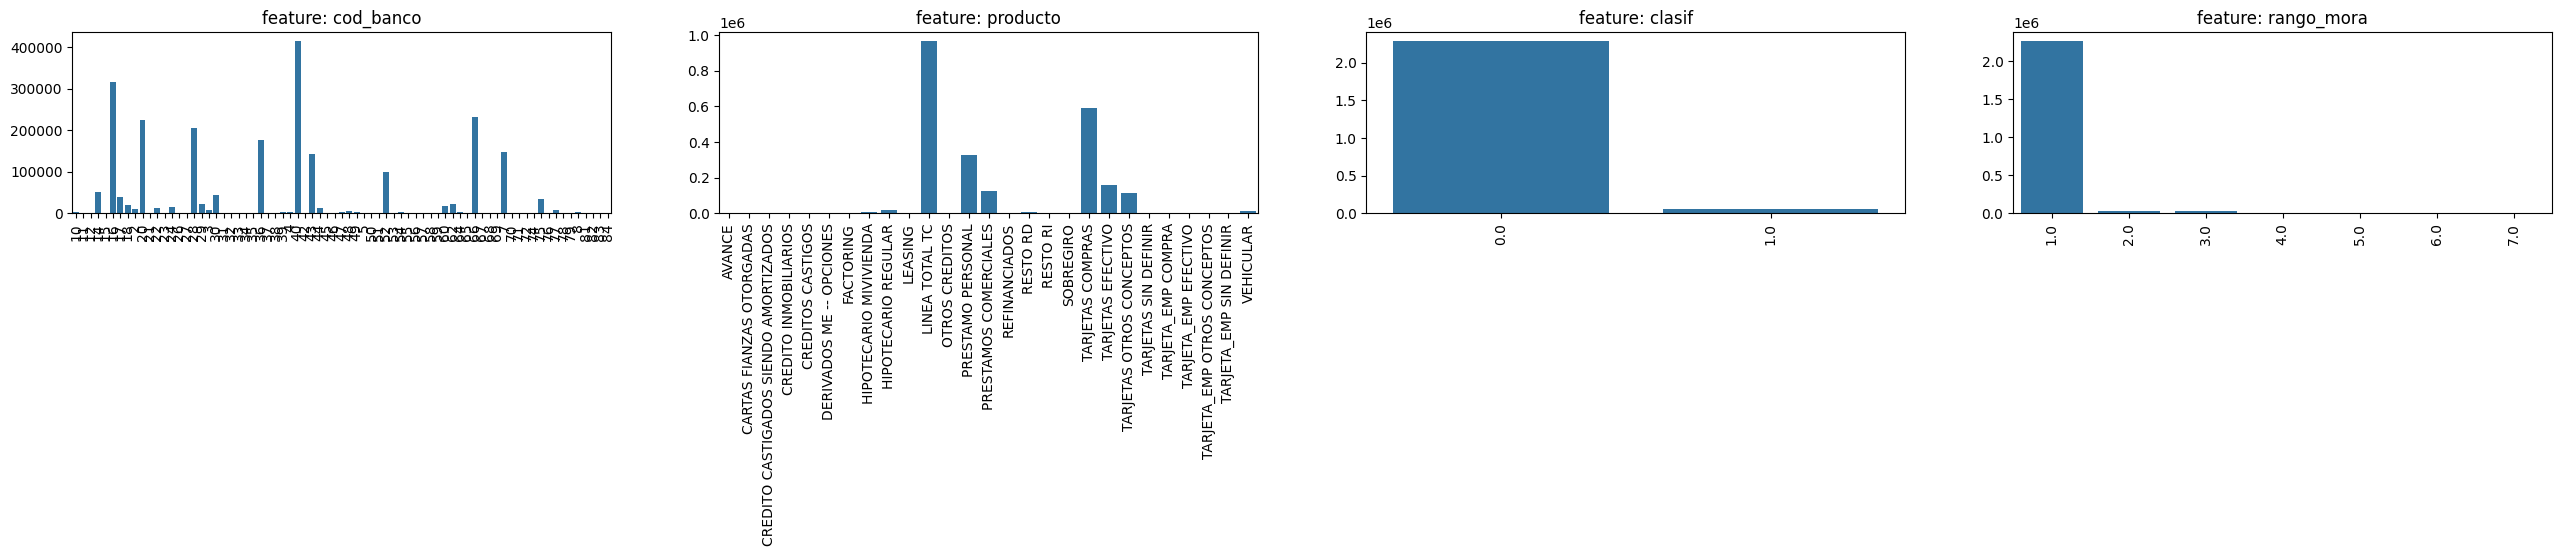

In [22]:
### visualizacion variables de tipo string

### Definiendo variables a graficar
features = df.drop(["codmes","id_persona"], axis=1).select_dtypes(include=[object]).columns

### configuración de area de las gráficas
plt.figure(figsize=(32,32))
gs = gridspec.GridSpec(8, 4)
gs.update(hspace=0.8)

### Graficando las variables
df["VALOR"]=1
for i, f in enumerate(features):
    ax = plt.subplot(gs[i])
    valor=df.groupby(f)["VALOR"].sum().reset_index()
    # sns.barplot(valor[f],valor["VALOR"])
    sns.barplot(data = valor, x = f, y = "VALOR")
    ax.set_xlabel('')
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    ax.set_ylabel('')
    ax.set_title('feature: ' + str(f))

df.drop("VALOR", axis=1, inplace=True)
plt.show()

### Preparacion de los datos

- Armando el target: Vamos a definir el objetivo del modelo, es decir estudiaremos cual es la finalidad del modelo analítico que queremos desarrollar.
- Universo de estudio: Vamos a definir cual es la población, es decir sobre que personas queremos desarrollar el caso.
- Preparación de variables predictoras: Vamos a procesar la información RCC con la finalidad de resolver el caso, es decir crearemos variables predictoras que creemos influencian en el resultado final osea el caso de estudio. Entonces, crearemos variables por las distintas variables que tenemos como: deuda por banco, deuda por producto, deuda por tipo_credito, deuda por riesgo, deuda por clasificación deudor, linea disponible en la TC. Asimismo, sobre estas vamos a crear variables del pasado como promedios, incrementos, varianza, frecuencia.

#### Armando el target - ingreso de clientes

Definiendo el problema a resolver, es decir estimar el ingreso de las personas en RCC.

In [24]:
# SI ESTAMOS EN LOCAL:

### cargamos los ingresos de los clientes
# df_income = pd.read_csv('ib_base_inicial_train.csv').drop(["codtarget", "margen", "cem", "linea_ofrecida"], axis=1)

In [54]:
# SI ESTAMOS EN COLAB:

### cargamos los ingresos de los clientes
enlace_original = 'https://drive.google.com/file/d/1aW8FqixgMQ6QvSzkvFeudvFKbFZxhWaW/view?usp=sharing'
df_income = descargar_y_leer_archivo_desde_drive(enlace_original,"base_inicial.csv")

Downloading...
From: https://drive.google.com/uc?id=1aW8FqixgMQ6QvSzkvFeudvFKbFZxhWaW
To: /content/base_inicial.csv
100%|██████████| 7.29M/7.29M [00:00<00:00, 166MB/s]


In [56]:
df_income = df_income.drop(["codtarget", "margen", "cem", "linea_ofrecida"], axis=1)

In [55]:
print("El numero de filas del dataframe es: ",df_income.shape[0])

El numero de filas del dataframe es:  212665


In [57]:
### Primeros 5 lineas del dataframe
df_income.head()

codmes  id_persona  ingreso_neto
0  201901      165747          1781
1  201903      100117          2106
2  201901       65751          3083
3  201901       58047          1814
4  201901      113221          2153

In [58]:
### Cantidad de registros por mes
df_income.groupby("codmes")["id_persona"].count()

codmes
201901    54088
201902    46125
201903    52387
201904    60065
Name: id_persona, dtype: int64

In [59]:
### Valores Duplicados
df_income[df_income[["id_persona", "codmes"]].duplicated()].head()

Empty DataFrame
Columns: [codmes, id_persona, ingreso_neto]
Index: []

In [60]:
### Revisión de datos nulos
df_income.isna().sum()

codmes          0
id_persona      0
ingreso_neto    0
dtype: int64

<ipython-input-61-daa888b0ad03>:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_income[f], color='b')


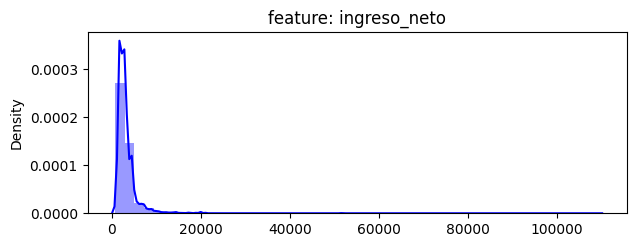

In [61]:
### visualizacion del target

### Definiendo variables a graficar
features = df_income.drop(["codmes", "id_persona"], axis=1).select_dtypes(exclude=[object])

### configuración de area de las gráficas
plt.figure(figsize=(32,32))
gs = gridspec.GridSpec(8, 4)
gs.update(hspace=0.8)

### Graficando las variables
for i, f in enumerate(features):
    ax = plt.subplot(gs[i])
    sns.distplot(df_income[f], color='b')
    ax.set_xlabel('')
    ax.set_title('feature: ' + str(f))

plt.show()

**Para la variable target (ingreso del cliente) se puede hacer una transformación logaritmica**

#### Universo de clientes

Definimos la población a entrenar por el algoritmo

#### Preparación de variables predictoras - Variables para todas las personas en RCC

##### Linea Disponible TC

In [63]:
df[df['producto']=='LINEA TOTAL TC'].head()

codmes  id_persona  cod_banco        producto  clasif  mto_saldo  \
292  201808      222772         28  LINEA TOTAL TC     NaN    730.000   
297  201811       98508         28  LINEA TOTAL TC     NaN   8030.000   
302  201805      124168         28  LINEA TOTAL TC     NaN   4745.000   
306  201804        6655         28  LINEA TOTAL TC     NaN   1450.875   
307  201804       87098         28  LINEA TOTAL TC     NaN   3431.000   

     rango_mora  
292         NaN  
297         NaN  
302         NaN  
306         NaN  
307         NaN

In [64]:
### Filtrando las personas que tienen Linea de TC
df_rcc_lineatc = df[df['producto']=='LINEA TOTAL TC']

### Cambiando el nombre de la variable saldo por linea
df_rcc_lineatc.columns = ['mto_linea' if x=='mto_saldo' else x for x in df_rcc_lineatc.columns]

### Filtrando las personas que tienen deuda de TC
df_rcc_tc = df[df['producto'].str.contains('TARJETA')]
df_rcc_tc = df_rcc_tc[df_rcc_tc["cod_banco"]!="73"]
df_rcc_tc = df_rcc_tc[df_rcc_tc["cod_banco"]!="49"]

### Pivoteando la variable linea de TC por banco - utilizamos la función tabla_pivot1
df_rcc_lineatc_pivot_banco_s1 = tabla_pivot1(df_rcc_lineatc,'cod_banco','mto_linea')
df_rcc_lineatc_pivot_banco_s1.fillna(0, inplace=True)

### Pivoteando la variable deuda de TC por banco - utilizamos la función tabla_pivot1
df_rcc_tc_pivot_banco_s1 = tabla_pivot1(df_rcc_tc,'cod_banco','mto_saldo')
df_rcc_tc_pivot_banco_s1.fillna(0, inplace=True)

In [65]:
df[(df["producto"]=="LINEA TOTAL TC")].head()

codmes  id_persona  cod_banco        producto  clasif  mto_saldo  \
292  201808      222772         28  LINEA TOTAL TC     NaN    730.000   
297  201811       98508         28  LINEA TOTAL TC     NaN   8030.000   
302  201805      124168         28  LINEA TOTAL TC     NaN   4745.000   
306  201804        6655         28  LINEA TOTAL TC     NaN   1450.875   
307  201804       87098         28  LINEA TOTAL TC     NaN   3431.000   

     rango_mora  
292         NaN  
297         NaN  
302         NaN  
306         NaN  
307         NaN

In [66]:
df_rcc_lineatc_pivot_banco_s1[df_rcc_lineatc_pivot_banco_s1["id_persona"]==25]#linea de TC

codmes  id_persona  mto_linea_6  mto_linea_7  mto_linea_14  \
42597    201801          25          0.0          0.0           0.0   
112243   201802          25          0.0          0.0           0.0   
209013   201803          25          0.0          0.0           0.0   
332124   201804          25          0.0          0.0           0.0   
478235   201805          25          0.0          0.0           0.0   
645117   201806          25          0.0          0.0           0.0   
831979   201807          25          0.0          0.0           0.0   
1021277  201808          25          0.0          0.0           0.0   
1213190  201809          25          0.0          0.0           0.0   
1407689  201810          25          0.0          0.0           0.0   
1603799  201811          25          0.0          0.0           0.0   
1801992  201812          25          0.0          0.0           0.0   
1978501  201901          25          0.0          0.0           0.0   
2132706  201902          25          0.0          0.0           0.0   
2268479  201903          25          0.0          0.0           0.0   

         mto_linea_15  mto_linea_16  mto_linea_17  mto_linea_20  mto_linea_24  \
42597             0.0           0.0           0.0         730.0           0.0   
112243            0.0           0.0           0.0         730.0           0.0   
209013            0.0           0.0           0.0         730.0           0.0   
332124            0.0           0.0           0.0         876.0           0.0   
478235            0.0           0.0           0.0         876.0           0.0   
645117            0.0           0.0           0.0         876.0           0.0   
831979            0.0           0.0           0.0         876.0           0.0   
1021277           0.0           0.0           0.0         876.0           0.0   
1213190           0.0           0.0           0.0         876.0           0.0   
1407689           0.0           0.0           0.0         876.0           0.0   
1603799           0.0           0.0           0.0        1752.0           0.0   
1801992           0.0           0.0           0.0        1752.0           0.0   
1978501           0.0           0.0           0.0        1752.0           0.0   
2132706           0.0           0.0           0.0        1752.0           0.0   
2268479           0.0           0.0           0.0        1752.0           0.0   

         mto_linea_28  mto_linea_35  mto_linea_36  mto_linea_40  mto_linea_43  \
42597             0.0           0.0           0.0           0.0           0.0   
112243            0.0           0.0           0.0           0.0           0.0   
209013            0.0           0.0           0.0           0.0           0.0   
332124            0.0           0.0           0.0           0.0           0.0   
478235            0.0           0.0           0.0           0.0           0.0   
645117            0.0           0.0           0.0           0.0           0.0   
831979            0.0           0.0           0.0           0.0           0.0   
1021277           0.0           0.0           0.0           0.0           0.0   
1213190           0.0           0.0           0.0           0.0           0.0   
1407689           0.0           0.0           0.0           0.0           0.0   
1603799           0.0           0.0           0.0           0.0           0.0   
1801992           0.0           0.0           0.0           0.0           0.0   
1978501           0.0           0.0           0.0           0.0           0.0   
2132706           0.0           0.0           0.0           0.0           0.0   
2268479           0.0           0.0           0.0           0.0           0.0   

         mto_linea_48  mto_linea_52  mto_linea_53  mto_linea_66  mto_linea_75  \
42597             0.0           0.0           0.0           0.0           0.0   
112243            0.0           0.0           0.0           0.0           0.0   
209013            0.0           0.0

In [67]:
df_rcc_tc_pivot_banco_s1[df_rcc_tc_pivot_banco_s1["id_persona"]==25]# deuda de TC

codmes  id_persona  mto_saldo_6  mto_saldo_7  mto_saldo_14  \
36890    201801          25          0.0          0.0           0.0   
96113    201802          25          0.0          0.0           0.0   
177471   201803          25          0.0          0.0           0.0   
280897   201804          25          0.0          0.0           0.0   
403985   201805          25          0.0          0.0           0.0   
545254   201806          25          0.0          0.0           0.0   
702860   201807          25          0.0          0.0           0.0   
862188   201808          25          0.0          0.0           0.0   
1024660  201809          25          0.0          0.0           0.0   
1189108  201810          25          0.0          0.0           0.0   
1526758  201812          25          0.0          0.0           0.0   
1678251  201901          25          0.0          0.0           0.0   
1809735  201902          25          0.0          0.0           0.0   
1925300  201903          25          0.0          0.0           0.0   

         mto_saldo_15  mto_saldo_16  mto_saldo_17  mto_saldo_20  mto_saldo_24  \
36890             0.0           0.0           0.0      411.6616           0.0   
96113             0.0           0.0           0.0      376.0595           0.0   
177471            0.0           0.0           0.0      338.2893           0.0   
280897            0.0           0.0           0.0      300.4461           0.0   
403985            0.0           0.0           0.0      260.8509           0.0   
545254            0.0           0.0           0.0      220.8834           0.0   
702860            0.0           0.0           0.0      179.1566           0.0   
862188            0.0           0.0           0.0      136.4370           0.0   
1024660           0.0           0.0           0.0       92.3231           0.0   
1189108           0.0           0.0           0.0       46.5375           0.0   
1526758           0.0           0.0           0.0      120.5960           0.0   
1678251           0.0           0.0           0.0       95.8490           0.0   
1809735           0.0           0.0           0.0       90.2864           0.0   
1925300           0.0           0.0           0.0       84.5194           0.0   

         mto_saldo_28  mto_saldo_35  mto_saldo_36  mto_saldo_40  mto_saldo_43  \
36890             0.0           0.0           0.0           0.0           0.0   
96113             0.0           0.0           0.0           0.0           0.0   
177471            0.0           0.0           0.0           0.0           0.0   
280897            0.0           0.0           0.0           0.0           0.0   
403985            0.0           0.0           0.0           0.0           0.0   
545254            0.0           0.0           0.0           0.0           0.0   
702860            0.0           0.0           0.0           0.0           0.0   
862188            0.0           0.0           0.0           0.0           0.0   
1024660           0.0           0.0           0.0           0.0           0.0   
1189108           0.0           0.0           0.0           0.0           0.0   
1526758           0.0           0.0           0.0           0.0           0.0   
1678251           0.0           0.0           0.0           0.0           0.0   
1809735           0.0           0.0           0.0           0.0           0.0   
1925300           0.0           0.0           0.0           0.0           0.0   

         mto_saldo_48  mto_saldo_52  mto_saldo_53  mto_saldo_66  mto_saldo_75  \
36890             0.0           0.0           0.0           0.0           0.0   
96113             0.0           0.0           0.0           0.0           0.0   
177471            0.0           0.0           0.0           0.0           0.0   
280897            0.0           0.0           0.0           0.0           0.0   
403985            0.0           0.0           0.0           0.0           0.0   
545254            0.0    

In [68]:
from pandas.core.common import flatten

### Calculando la linea desponible TC (linea de TC - deuda de TC)
df_rcc_dif_tc_pivot_banco_s1 = df_rcc_lineatc_pivot_banco_s1.merge(df_rcc_tc_pivot_banco_s1, how='left', on=['codmes','id_persona'])
### Calculando la linea desponible TC (linea de TC - deuda de TC)
for linea, monto in pd.DataFrame({'linea':df_rcc_lineatc_pivot_banco_s1.columns[2:],'saldo':df_rcc_tc_pivot_banco_s1.columns[2:]}).values:
    try:
        num = int(linea.split('_')[2])
        df_rcc_dif_tc_pivot_banco_s1['saldo_diftc_'+str(num)] = df_rcc_dif_tc_pivot_banco_s1[linea] - df_rcc_dif_tc_pivot_banco_s1[monto]
    except ValueError:
        df_rcc_dif_tc_pivot_banco_s1['saldo_diftc_total'] = df_rcc_dif_tc_pivot_banco_s1[linea] - df_rcc_dif_tc_pivot_banco_s1[monto]
df_rcc_dif_tc_pivot_banco_s1.drop(df_rcc_dif_tc_pivot_banco_s1.columns[2:(len(df_rcc_lineatc_pivot_banco_s1.columns[2:])*2+2)], axis=1, inplace=True)
columnas = ["codmes", "id_persona"]
columnas.append(list(df_rcc_dif_tc_pivot_banco_s1[df_rcc_dif_tc_pivot_banco_s1.columns[2:]].sum().reset_index().sort_values([0], ascending=False)["index"][0:14]))
columnas = list(flatten(columnas))
df_rcc_dif_tc_pivot_banco_s1 = df_rcc_dif_tc_pivot_banco_s1[columnas]
for columna in df_rcc_dif_tc_pivot_banco_s1.columns[2:]:
  df_rcc_dif_tc_pivot_banco_s1.loc[df_rcc_dif_tc_pivot_banco_s1[columna]<0,columna] = 0
  df_rcc_dif_tc_pivot_banco_s1[columna] = df_rcc_dif_tc_pivot_banco_s1[columna].replace(0.0,np.NaN)

<ipython-input-68-7f810e24e6cc>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rcc_dif_tc_pivot_banco_s1[columna] = df_rcc_dif_tc_pivot_banco_s1[columna].replace(0.0,np.NaN)


In [69]:
df_rcc_dif_tc_pivot_banco_s1[df_rcc_dif_tc_pivot_banco_s1["id_persona"]==25]#linea desponible TC

codmes  id_persona  saldo_diftc_total  saldo_diftc_16  saldo_diftc_7  \
42597    201801          25           318.3384             NaN            NaN   
112243   201802          25           353.9405             NaN            NaN   
209013   201803          25           391.7107             NaN            NaN   
332124   201804          25           575.5539             NaN            NaN   
478235   201805          25           615.1491             NaN            NaN   
645117   201806          25           655.1166             NaN            NaN   
831979   201807          25           696.8434             NaN            NaN   
1021277  201808          25           739.5630             NaN            NaN   
1213190  201809          25           783.6769             NaN            NaN   
1407689  201810          25           829.4625             NaN            NaN   
1603799  201811          25                NaN             NaN            NaN   
1801992  201812          25          1631.4040             NaN            NaN   
1978501  201901          25          1656.1510             NaN            NaN   
2132706  201902          25          1661.7136             NaN            NaN   
2268479  201903          25          1667.4806             NaN            NaN   

         saldo_diftc_40  saldo_diftc_28  saldo_diftc_52  saldo_diftc_66  \
42597               NaN             NaN             NaN             NaN   
112243              NaN             NaN             NaN             NaN   
209013              NaN             NaN             NaN             NaN   
332124              NaN             NaN             NaN             NaN   
478235              NaN             NaN             NaN             NaN   
645117              NaN             NaN             NaN             NaN   
831979              NaN             NaN             NaN             NaN   
1021277             NaN             NaN             NaN             NaN   
1213190             NaN             NaN             NaN             NaN   
1407689             NaN             NaN             NaN             NaN   
1603799             NaN             NaN             NaN             NaN   
1801992             NaN             NaN             NaN             NaN   
1978501             NaN             NaN             NaN             NaN   
2132706             NaN             NaN             NaN             NaN   
2268479             NaN             NaN             NaN             NaN   

         saldo_diftc_36  saldo_diftc_20  saldo_diftc_43  saldo_diftc_75  \
42597               NaN        318.3384             NaN             NaN   
112243              NaN        353.9405             NaN             NaN   
209013              NaN        391.7107             NaN             NaN   
332124              NaN        575.5539             NaN             NaN   
478235              NaN        615.1491             NaN             NaN   
645117              NaN        655.1166             NaN             NaN   
831979              NaN        696.8434             NaN             NaN   
1021277             NaN        739.5630             NaN             NaN   
1213190             NaN        783.6769             NaN             NaN   
1407689             NaN        829.4625             NaN             NaN   
1603799             NaN             NaN             NaN             NaN   
1801992             NaN       1631.4040             NaN             NaN   
1978501             NaN       1656.1510             NaN             NaN   
2132706             NaN       1661.7136             NaN             NaN   
2268479             NaN       1667.4806             NaN             NaN   

         saldo_diftc_17  saldo_diftc_14  saldo_diftc_48  
42597               NaN             NaN             NaN  
112243              NaN             NaN             NaN  
209013              NaN             NaN             NaN  
332124              NaN             NaN             NaN  
478235              

In [ ]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

### Generando nuevas variables a partir de la linea disponible TC - utilizamos la función tabla_pivot2 para crear las variables del pasado como promedios, incrementos, frecuencia, varianza.
#df_rcc_dif_tc_pivot_banco_s6 = pd.DataFrame()
df_rcc_dif_tc_pivot_banco_s6 = []
for mes in [201901, 201902, 201903, 201904]:
  fecha = str(mes)+"01"
  fecha = datetime.strptime(fecha,  "%Y%m%d")

  ### fecha inicio
  fecha_inicio = fecha - relativedelta(months=12)
  fecha_inicio_y = str(fecha_inicio.strftime("%Y"))
  fecha_inicio_m = str(fecha_inicio.strftime("%m"))
  fecha_inicio = int(fecha_inicio_y+fecha_inicio_m)

  ### fecha final
  fecha_final = fecha - relativedelta(months=1)
  fecha_final_y = str(fecha_final.strftime("%Y"))
  fecha_final_m = str(fecha_final.strftime("%m"))
  fecha_final = int(fecha_final_y+fecha_final_m)
  print("Mes de ejecución:", mes)
  print("Inicio:", fecha_inicio)
  print("Final:", fecha_final)
  print("--------------------------------------------------------------------------------------------------------------------------------------------------------------------")
  df_rcc_dif_tc_pivot_banco = tabla_pivot2(df_rcc_dif_tc_pivot_banco_s1, fecha_inicio, fecha_final, 12)
  #df_rcc_dif_tc_pivot_banco_s6 = df_rcc_dif_tc_pivot_banco_s6.append(df_rcc_dif_tc_pivot_banco)
  df_rcc_dif_tc_pivot_banco_s6.append(df_rcc_dif_tc_pivot_banco)

df_rcc_dif_tc_pivot_banco_s6 = pd.concat(df_rcc_dif_tc_pivot_banco_s6)
df_rcc_dif_tc_pivot_banco_s1.fillna(0, inplace=True)

Mes de ejecución: 201901
Inicio: 201801
Final: 201812
--------------------------------------------------------------------------------------------------------------------------------------------------------------------


<ipython-input-6-d05dc1fdac69>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
<ipython-input-6-d05dc1fdac69>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
<ipython-input-6-d05dc1fdac69>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

In [ ]:
### grupo de variables con respecto a la LINEA DISPONIBLE EN TC
df_rcc_dif_tc_pivot_banco_s6[df_rcc_dif_tc_pivot_banco_s6["id_persona"]==25]

##### Deuda a nivel producto

In [ ]:
### Quitando producto = "%LINEA%"
df = df[~(df["producto"].str.contains('LINEA'))]

### limpiando el campo producto de RCC
df['producto'] = df['producto'].str.replace('_',' ')
df['producto'] = df['producto'].str.replace('-',' ')
df['producto'] = df['producto'].str.replace('--',' ')

C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\828066812.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['producto'] = df['producto'].str.replace('_',' ')
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\828066812.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['producto'] = df['producto'].str.replace('-',' ')
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\828066812.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

In [ ]:
### Pivoteando la variable deuda por producto - utilizamos la función tabla_pivot1
df_pivot_producto_s1 = tabla_pivot1(df,'producto','mto_saldo')
columnas = ["codmes", "id_persona"]
columnas.append(list(df_pivot_producto_s1[df_pivot_producto_s1.columns[2:]].sum().reset_index().sort_values([0], ascending=False)["index"][0:14]))
columnas = list(flatten(columnas))
df_pivot_producto_s1 = df_pivot_producto_s1[columnas]

In [ ]:
df_pivot_producto_s1[df_pivot_producto_s1["id_persona"]==25]

codmes  id_persona  mto_saldo_tarjetascompras  \
8725    201801          25                   6.020202   
23073   201802          25                   5.929747   
43583   201803          25                   5.823901   
69886   201804          25                   5.705268   
101431  201805          25                   5.563949   
137975  201806          25                   5.397635   
179227  201807          25                   5.188260   
220811  201808          25                   4.915863   
262909  201809          25                   4.525294   
305401  201810          25                   3.840258   
348439  201811          25                        NaN   
391739  201812          25                   4.792446   
430595  201901          25                   4.562774   
464763  201902          25                   4.502987   
494580  201903          25                   4.436981   

        mto_saldo_prestamopersonal  mto_saldo_tarjetasefectivo  \
8725                      7.095001                         NaN   
23073                     6.889044                         NaN   
43583                     6.614972                         NaN   
69886                     6.614972                         NaN   
101431                    8.329823                         NaN   
137975                    8.262951                         NaN   
179227                    8.182457                         NaN   
220811                    8.093134                         NaN   
262909                    7.991559                         NaN   
305401                    7.873198                         NaN   
348439                   16.125615                         NaN   
391739                   23.427217                         NaN   
430595                   24.448064                         NaN   
464763                   24.283169                         NaN   
494580                   24.068444                         NaN   

        mto_saldo_prestamoscomerciales  mto_saldo_tarjetasotrosconceptos  \
8725                               NaN                               NaN   
23073                              NaN                               NaN   
43583                              NaN                               NaN   
69886                              NaN                               NaN   
101431                             NaN                               NaN   
137975                             NaN                               NaN   
179227                             NaN                               NaN   
220811                             NaN                               NaN   
262909                             NaN                               NaN   
305401                             NaN                               NaN   
348439                             NaN                               NaN   
391739                             NaN                               NaN   
430595                             NaN                               NaN   
464763                             NaN                               NaN   
494580                             NaN                               NaN   

        mto_saldo_hipotecarioregular  mto_saldo_vehicular  \
8725                             NaN                  NaN   
23073                            NaN                  NaN   
43583                            NaN                  NaN   
69886                            NaN                  NaN   
101431                           NaN                  NaN   
137975                           NaN                  NaN   
179227                           NaN                  NaN   
220811                           NaN                  NaN   
262909                           NaN                  NaN   
305401                           NaN                  NaN   
348439                           NaN                  NaN   
391739                           NaN                  NaN   
430595                      

In [ ]:
### Generando nuevas variables a partir de la deuda por producto - utilizamos la función tabla_pivot2 para crear las variables del pasado como promedios, incrementos, frecuencia, varianza.
#df_pivot_producto_s6 = pd.DataFrame()
df_pivot_producto_s6 = []
for mes in [201901, 201902, 201903, 201904]:
  fecha = str(mes)+"01"
  fecha = datetime.strptime(fecha,  "%Y%m%d")

  ### fecha inicio
  fecha_inicio = fecha - relativedelta(months=6)
  fecha_inicio_y = str(fecha_inicio.strftime("%Y"))
  fecha_inicio_m = str(fecha_inicio.strftime("%m"))
  fecha_inicio = int(fecha_inicio_y+fecha_inicio_m)

  ### fecha final
  fecha_final = fecha - relativedelta(months=1)
  fecha_final_y = str(fecha_final.strftime("%Y"))
  fecha_final_m = str(fecha_final.strftime("%m"))
  fecha_final = int(fecha_final_y+fecha_final_m)
  print("Mes de ejecución:", mes)
  print("--------------------------------------------------------------------------------------------------------------------------------------------------------------------")
  df_pivot_producto = tabla_pivot2(df_pivot_producto_s1, fecha_inicio, fecha_final, 12)
  #df_pivot_producto_s6 = df_pivot_producto_s6.append(df_pivot_producto)
  df_pivot_producto_s6.append(df_pivot_producto)
df_pivot_producto_s6 = pd.concat(df_pivot_producto_s6)
df_pivot_producto_s1.fillna(0, inplace=True)

Mes de ejecución: 201901
--------------------------------------------------------------------------------------------------------------------------------------------------------------------


C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCop

C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCop

C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCop

C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCop

C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCop

C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCop

C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCop

C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:64: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df1["year"] = df1["codmes"].astype(str).str[:4]
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:65: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df1["month"] = df1["codmes"].astype(str).str[4:]
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:66: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

Mes de ejecución: 201902
--------------------------------------------------------------------------------------------------------------------------------------------------------------------


C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCop

C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCop

C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCop

C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCop

C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCop

C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCop

C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCop

C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:64: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df1["year"] = df1["codmes"].astype(str).str[:4]
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:65: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df1["month"] = df1["codmes"].astype(str).str[4:]
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:66: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

Mes de ejecución: 201903
--------------------------------------------------------------------------------------------------------------------------------------------------------------------


C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCop

C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCop

C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCop

C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCop

C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCop

C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCop

C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCop

C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:64: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df1["year"] = df1["codmes"].astype(str).str[:4]
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:65: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df1["month"] = df1["codmes"].astype(str).str[4:]
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:66: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

Mes de ejecución: 201904
--------------------------------------------------------------------------------------------------------------------------------------------------------------------


C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCop

C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCop

C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCop

C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCop

C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCop

C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCop

C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCop

C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:64: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df1["year"] = df1["codmes"].astype(str).str[:4]
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:65: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df1["month"] = df1["codmes"].astype(str).str[4:]
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:66: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

In [ ]:
df_pivot_producto_s6[df_pivot_producto_s6["id_persona"]==25]

id_persona  mto_saldo_tarjetascompras_1  mto_saldo_tarjetascompras_2  \
212519          25                     4.792446                     0.000000   
209791          25                     4.562774                     4.792446   
201861          25                     4.502987                     4.562774   
189186          25                     4.436981                     4.502987   

        mto_saldo_tarjetascompras_3  mto_saldo_tarjetascompras_4  \
212519                     3.840258                     4.525294   
209791                     0.000000                     3.840258   
201861                     4.792446                     0.000000   
189186                     4.562774                     4.792446   

        mto_saldo_tarjetascompras_5  mto_saldo_tarjetascompras_6  \
212519                     4.915863                     5.188260   
209791                     4.525294                     4.915863   
201861                     3.840258                     4.525294   
189186                     0.000000                     3.840258   

        mto_saldo_tarjetascompras_7  mto_saldo_tarjetascompras_8  \
212519                          0.0                          0.0   
209791                          0.0                          0.0   
201861                          0.0                          0.0   
189186                          0.0                          0.0   

        mto_saldo_tarjetascompras_9  mto_saldo_tarjetascompras_10  \
212519                          0.0                           0.0   
209791                          0.0                           0.0   
201861                          0.0                           0.0   
189186                          0.0                           0.0   

        mto_saldo_tarjetascompras_11  mto_saldo_tarjetascompras_12  \
212519                           0.0                           0.0   
209791                           0.0                           0.0   
201861                           0.0                           0.0   
189186                           0.0                           0.0   

        mto_saldo_tarjetascompras_prom_3m  mto_saldo_tarjetascompras_prom_6m  \
212519                           4.316352                           4.652424   
209791                           4.677610                           4.527327   
201861                           4.619402                           4.444752   
189186                           4.500914                           4.427089   

        mto_saldo_tarjetascompras_prom_9m  mto_saldo_tarjetascompras_prom_12m  \
212519                           4.652424                            4.652424   
209791                           4.527327                            4.527327   
201861                           4.444752                            4.444752   
189186                           4.427089                            4.427089   

        mto_saldo_tarjetascompras_freq_3m  mto_saldo_tarjetascompras_freq_6m  \
212519                                  2                                  5   
209791                                  2                                  5   
201861                                  3                                  5   
189186                                  3                                  5   

        mto_saldo_tarjetascompras_freq_9m  mto_saldo_tarjetascompras_freq_12m  \
212519                                  5                                   5   
209791                                  5                                   5   
201861                                  5                                   5   
189186                                  5                                   5   

        mto_saldo_tarjetascompras_increm_3m  \
212519                             0.247949   
209791                             1.000000   
201861                            -0.060399   
189186                            -0.027569   

        mto_saldo_tarjetascompras_inc

##### Deuda a nivel banco

In [ ]:
### Pivoteando la variable deuda por banco - utilizamos la función tabla_pivot1
df["cod_banco"] = "banco"+df["cod_banco"].astype(str)
df_pivot_banco_s1 = tabla_pivot1(df,'cod_banco','mto_saldo')
columnas = ["codmes", "id_persona"]
columnas.append(list(df_pivot_banco_s1[df_pivot_banco_s1.columns[2:]].sum().reset_index().sort_values([0], ascending=False)["index"][0:14]))
columnas = list(flatten(columnas))
df_pivot_banco_s1 = df_pivot_banco_s1[columnas]

C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\896134034.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["cod_banco"] = "banco"+df["cod_banco"].astype(str)


In [ ]:
df_pivot_banco_s1[df_pivot_banco_s1["id_persona"]==25]

codmes  id_persona  mto_saldo_total  mto_saldo_banco16  \
8725    201801          25        13.115203                NaN   
23073   201802          25        12.818792                NaN   
43583   201803          25        12.438874                NaN   
69886   201804          25        12.320241                NaN   
101431  201805          25        13.893772                NaN   
137975  201806          25        13.660586                NaN   
179227  201807          25        13.370718                NaN   
220811  201808          25        13.008997                NaN   
262909  201809          25        12.516853                NaN   
305401  201810          25        11.713456                NaN   
348439  201811          25        16.125615                NaN   
391739  201812          25        28.219664                NaN   
430595  201901          25        29.010838                NaN   
464763  201902          25        28.786156                NaN   
494580  201903          25        28.505425                NaN   

        mto_saldo_banco40  mto_saldo_banco28  mto_saldo_banco7  \
8725                  NaN                NaN               NaN   
23073                 NaN                NaN               NaN   
43583                 NaN                NaN               NaN   
69886                 NaN                NaN               NaN   
101431                NaN                NaN               NaN   
137975                NaN                NaN               NaN   
179227                NaN                NaN               NaN   
220811                NaN                NaN               NaN   
262909                NaN                NaN               NaN   
305401                NaN                NaN               NaN   
348439                NaN                NaN          8.390123   
391739                NaN                NaN          8.390123   
430595                NaN                NaN          8.328391   
464763                NaN                NaN          8.249019   
494580                NaN                NaN          8.156212   

        mto_saldo_banco20  mto_saldo_banco66  mto_saldo_banco36  \
8725             6.020202                NaN           7.095001   
23073            5.929747                NaN           6.889044   
43583            5.823901                NaN           6.614972   
69886            5.705268                NaN           6.614972   
101431           5.563949                NaN           8.329823   
137975           5.397635                NaN           8.262951   
179227           5.188260                NaN           8.182457   
220811           4.915863                NaN           8.093134   
262909           4.525294                NaN           7.991559   
305401           3.840258                NaN           7.873198   
348439                NaN                NaN           7.735492   
391739          12.260959                NaN           7.568581   
430595          11.962857                NaN           8.719590   
464763          11.817547                NaN           8.719590   
494580          11.653930                NaN           8.695283   

        mto_saldo_banco52  mto_saldo_banco43  mto_saldo_banco30  \
8725                  NaN                NaN                NaN   
23073                 NaN                NaN                NaN   
43583                 NaN                NaN                NaN   
69886                 NaN                NaN                NaN   
101431                NaN                NaN                NaN   
137975                NaN                NaN                NaN   
179227                NaN                NaN                NaN   
220811                NaN                NaN                NaN   
262909                NaN                NaN                NaN   
305401                NaN                NaN                NaN   
348439                NaN                NaN                NaN   
391739           

In [ ]:
### Generando nuevas variables a partir de la deuda por banco - utilizamos la función tabla_pivot2 para crear las variables del pasado como promedios, incrementos, frecuencia, varianza.
#df_pivot_banco_s6 = pd.DataFrame()
df_pivot_banco_s6 = []
for mes in [201901, 201902, 201903, 201904]:
  fecha = str(mes)+"01"
  fecha = datetime.strptime(fecha,  "%Y%m%d")

  ### fecha inicio
  fecha_inicio = fecha - relativedelta(months=6)
  fecha_inicio_y = str(fecha_inicio.strftime("%Y"))
  fecha_inicio_m = str(fecha_inicio.strftime("%m"))
  fecha_inicio = int(fecha_inicio_y+fecha_inicio_m)

  ### fecha final
  fecha_final = fecha - relativedelta(months=1)
  fecha_final_y = str(fecha_final.strftime("%Y"))
  fecha_final_m = str(fecha_final.strftime("%m"))
  fecha_final = int(fecha_final_y+fecha_final_m)
  print("Mes de ejecución:", mes)
  print("--------------------------------------------------------------------------------------------------------------------------------------------------------------------")
  df_pivot_banco = tabla_pivot2(df_pivot_banco_s1, fecha_inicio, fecha_final, 12)
  #df_pivot_banco_s6 = df_pivot_banco_s6.append(df_pivot_banco)
  df_pivot_banco_s6.append(df_pivot_banco)

df_pivot_banco_s6 = pd.concat(df_pivot_banco_s6)
df_pivot_banco_s1.fillna(0, inplace=True)

Mes de ejecución: 201901
--------------------------------------------------------------------------------------------------------------------------------------------------------------------


C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCop

C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCop

C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCop

C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCop

C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCop

C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCop

C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCop

C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:64: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df1["year"] = df1["codmes"].astype(str).str[:4]
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:65: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df1["month"] = df1["codmes"].astype(str).str[4:]
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:66: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

Mes de ejecución: 201902
--------------------------------------------------------------------------------------------------------------------------------------------------------------------


C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCop

C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCop

C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCop

C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCop

C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCop

C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCop

C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCop

C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:64: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df1["year"] = df1["codmes"].astype(str).str[:4]
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:65: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df1["month"] = df1["codmes"].astype(str).str[4:]
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:66: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

Mes de ejecución: 201903
--------------------------------------------------------------------------------------------------------------------------------------------------------------------


C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCop

C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCop

C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCop

C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCop

C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCop

C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCop

C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCop

C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:64: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df1["year"] = df1["codmes"].astype(str).str[:4]
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:65: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df1["month"] = df1["codmes"].astype(str).str[4:]
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:66: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

Mes de ejecución: 201904
--------------------------------------------------------------------------------------------------------------------------------------------------------------------


C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCop

C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCop

C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCop

C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCop

C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCop

C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCop

C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCop

C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:64: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df1["year"] = df1["codmes"].astype(str).str[:4]
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:65: PerformanceWarning: DataFrame is highly fragmented.  This is usually the

In [ ]:
df_pivot_banco_s6[df_pivot_banco_s6["id_persona"]==25]

id_persona  mto_saldo_total_1  mto_saldo_total_2  mto_saldo_total_3  \
212519          25          28.219664          16.125615          11.713456   
209791          25          29.010838          28.219664          16.125615   
201861          25          28.786156          29.010838          28.219664   
189186          25          28.505425          28.786156          29.010838   

        mto_saldo_total_4  mto_saldo_total_5  mto_saldo_total_6  \
212519          12.516853          13.008997          13.370718   
209791          11.713456          12.516853          13.008997   
201861          16.125615          11.713456          12.516853   
189186          28.219664          16.125615          11.713456   

        mto_saldo_total_7  mto_saldo_total_8  mto_saldo_total_9  \
212519                0.0                0.0                0.0   
209791                0.0                0.0                0.0   
201861                0.0                0.0                0.0   
189186                0.0                0.0                0.0   

        mto_saldo_total_10  mto_saldo_total_11  mto_saldo_total_12  \
212519                 0.0                 0.0                 0.0   
209791                 0.0                 0.0                 0.0   
201861                 0.0                 0.0                 0.0   
189186                 0.0                 0.0                 0.0   

        mto_saldo_total_prom_3m  mto_saldo_total_prom_6m  \
212519                18.686245                15.825884   
209791                24.452039                18.432570   
201861                28.672219                21.062097   
189186                28.767473                23.726859   

        mto_saldo_total_prom_9m  mto_saldo_total_prom_12m  \
212519                15.825884                 15.825884   
209791                18.432570                 18.432570   
201861                21.062097                 21.062097   
189186                23.726859                 23.726859   

        mto_saldo_total_freq_3m  mto_saldo_total_freq_6m  \
212519                        3                        6   
209791                        3                        6   
201861                        3                        6   
189186                        3                        6   

        mto_saldo_total_freq_9m  mto_saldo_total_freq_12m  \
212519                        6                         6   
209791                        6                         6   
201861                        6                         6   
189186                        6                         6   

        mto_saldo_total_increm_3m  mto_saldo_total_increm_6m  \
212519                   1.409166                   1.110557   
209791                   0.799053                   1.230060   
201861                   0.020074                   1.299792   
189186                  -0.017422                   1.433562   

        mto_saldo_total_increm_9m  mto_saldo_total_increm_12m  \
212519                        1.0                         1.0   
209791                        1.0                         1.0   
201861                        1.0                         1.0   
189186                        1.0                         1.0   

        mto_saldo_total_desv_3m  mto_saldo_total_desv_6m  \
212519                 2.350027                 5.650628   
209791                 8.545838                 9.057094   
201861                 7.221737                10.997319   
189186                 0.407707                11.860356   

        mto_saldo_total_desv_9m  mto_saldo_total_desv_12m  \
212519                 7.133308                  6.946452   
209791                 9.873798                  9.365435   
201861                11.904657                 11.274661   
189186                13.339387                 12.733638   

        mto_saldo_banco16_1  mto_saldo_banco16_2  mto_saldo_banco16_3  \
212519                  0.0                  0.0

##### Deuda a nivel clasif

In [ ]:
### Pivoteando la variable deuda por clasif - utilizamos la función tabla_pivot1
df["clasif"] = "clasif"+df["clasif"].astype(str)
df_pivot_clasif_s1 = tabla_pivot1(df,'clasif','mto_saldo')
columnas = ["codmes", "id_persona"]
columnas.append(list(df_pivot_clasif_s1[df_pivot_clasif_s1.columns[2:]].sum().reset_index().sort_values([0], ascending=False)["index"][0:14]))
columnas = list(flatten(columnas))
df_pivot_clasif_s1 = df_pivot_clasif_s1[columnas]

C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\2810284510.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["clasif"] = "clasif"+df["clasif"].astype(str)


In [ ]:
df_pivot_clasif_s1[df_pivot_clasif_s1["id_persona"]==25]

codmes  id_persona  mto_saldo_clasif0.0  mto_saldo_clasif1.0
8725    201801          25            13.115203                  NaN
23073   201802          25            12.818792                  NaN
43583   201803          25            12.438874                  NaN
69886   201804          25            12.320241                  NaN
101431  201805          25            13.893772                  NaN
137975  201806          25            13.660586                  NaN
179227  201807          25            13.370718                  NaN
220811  201808          25            13.008997                  NaN
262909  201809          25            12.516853                  NaN
305401  201810          25            11.713456                  NaN
348439  201811          25            16.125615                  NaN
391739  201812          25            28.219664                  NaN
430595  201901          25            29.010838                  NaN
464763  201902          25            28.786156                  NaN
494580  201903          25            28.505425                  NaN

In [ ]:
### Generando nuevas variables a partir de la deuda por tipo_credito - utilizamos la función tabla_pivot2 para crear las variables del pasado como promedios, incrementos, frecuencia, varianza.
#df_pivot_clasif_s6 = pd.DataFrame()
df_pivot_clasif_s6 = []
for mes in [201901, 201902, 201903, 201904]:
  fecha = str(mes)+"01"
  fecha = datetime.strptime(fecha,  "%Y%m%d")

  ### fecha inicio
  fecha_inicio = fecha - relativedelta(months=6)
  fecha_inicio_y = str(fecha_inicio.strftime("%Y"))
  fecha_inicio_m = str(fecha_inicio.strftime("%m"))
  fecha_inicio = int(fecha_inicio_y+fecha_inicio_m)

  ### fecha final
  fecha_final = fecha - relativedelta(months=1)
  fecha_final_y = str(fecha_final.strftime("%Y"))
  fecha_final_m = str(fecha_final.strftime("%m"))
  fecha_final = int(fecha_final_y+fecha_final_m)
  print("Mes de ejecución:", mes)
  print("--------------------------------------------------------------------------------------------------------------------------------------------------------------------")
  df_pivot_clasif = tabla_pivot2(df_pivot_clasif_s1, fecha_inicio, fecha_final, 6)
  #df_pivot_clasif_s6 = df_pivot_clasif_s6.append(df_pivot_clasif)
  df_pivot_clasif_s6.append(df_pivot_clasif)

df_pivot_clasif_s6 = pd.concat(df_pivot_clasif_s6)
df_pivot_clasif_s1.fillna(0, inplace=True)

Mes de ejecución: 201901
--------------------------------------------------------------------------------------------------------------------------------------------------------------------
Mes de ejecución: 201902
--------------------------------------------------------------------------------------------------------------------------------------------------------------------
Mes de ejecución: 201903
--------------------------------------------------------------------------------------------------------------------------------------------------------------------
Mes de ejecución: 201904
--------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [ ]:
df_pivot_clasif_s6[df_pivot_clasif_s6["id_persona"]==25]

id_persona  mto_saldo_clasif0.0_1  mto_saldo_clasif0.0_2  \
212519          25              28.219664              16.125615   
209791          25              29.010838              28.219664   
201861          25              28.786156              29.010838   
189186          25              28.505425              28.786156   

        mto_saldo_clasif0.0_3  mto_saldo_clasif0.0_4  mto_saldo_clasif0.0_5  \
212519              11.713456              12.516853              13.008997   
209791              16.125615              11.713456              12.516853   
201861              28.219664              16.125615              11.713456   
189186              29.010838              28.219664              16.125615   

        mto_saldo_clasif0.0_6  mto_saldo_clasif0.0_prom_3m  \
212519              13.370718                    18.686245   
209791              13.008997                    24.452039   
201861              12.516853                    28.672219   
189186              11.713456                    28.767473   

        mto_saldo_clasif0.0_prom_6m  flg_mto_saldo_clasif0.0_1  \
212519                    15.825884                          1   
209791                    18.432570                          1   
201861                    21.062097                          1   
189186                    23.726859                          1   

        flg_mto_saldo_clasif0.0_2  mto_saldo_clasif1.0_1  \
212519                          1                    0.0   
209791                          1                    0.0   
201861                          1                    0.0   
189186                          1                    0.0   

        mto_saldo_clasif1.0_2  mto_saldo_clasif1.0_3  mto_saldo_clasif1.0_4  \
212519                    0.0                    0.0                    0.0   
209791                    0.0                    0.0                    0.0   
201861                    0.0                    0.0                    0.0   
189186                    0.0                    0.0                    0.0   

        mto_saldo_clasif1.0_5  mto_saldo_clasif1.0_6  \
212519                    0.0                    0.0   
209791                    0.0                    0.0   
201861                    0.0                    0.0   
189186                    0.0                    0.0   

        mto_saldo_clasif1.0_prom_3m  mto_saldo_clasif1.0_prom_6m  \
212519                          0.0                          0.0   
209791                          0.0                          0.0   
201861                          0.0                          0.0   
189186                          0.0                          0.0   

        flg_mto_saldo_clasif1.0_1  flg_mto_saldo_clasif1.0_2  codmes  
212519                          0                          0  201901  
209791                          0                          0  201902  
201861                          0                          0  201903  
189186                          0                          0  201904

##### Deuda a nivel rango_mora

In [ ]:
### Pivoteando la variable deuda por riesgo - utilizamos la función tabla_pivot1
df["rango_mora"] = "rangomora"+df["rango_mora"].astype(str)
df_pivot_rangomora_s1 = tabla_pivot1(df,'rango_mora','mto_saldo')
columnas = ["codmes", "id_persona"]
columnas.append(list(df_pivot_rangomora_s1[df_pivot_rangomora_s1.columns[2:]].sum().reset_index().sort_values([0], ascending=False)["index"][0:14]))
columnas = list(flatten(columnas))
df_pivot_rangomora_s1 = df_pivot_rangomora_s1[columnas]

C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\3796831960.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["rango_mora"] = "rangomora"+df["rango_mora"].astype(str)


In [ ]:
df_pivot_rangomora_s1[df_pivot_rangomora_s1["id_persona"]==25]

codmes  id_persona  mto_saldo_rangomora1.0  mto_saldo_rangomora2.0  \
8725    201801          25               13.115203                     NaN   
23073   201802          25               12.818792                     NaN   
43583   201803          25               12.438874                     NaN   
69886   201804          25                5.705268                6.614972   
101431  201805          25               13.893772                     NaN   
137975  201806          25               13.660586                     NaN   
179227  201807          25               13.370718                     NaN   
220811  201808          25               13.008997                     NaN   
262909  201809          25               12.516853                     NaN   
305401  201810          25               11.713456                     NaN   
348439  201811          25               16.125615                     NaN   
391739  201812          25               28.219664                     NaN   
430595  201901          25               29.010838                     NaN   
464763  201902          25               28.786156                     NaN   
494580  201903          25               28.505425                     NaN   

        mto_saldo_rangomora3.0  mto_saldo_rangomora4.0  \
8725                       NaN                     NaN   
23073                      NaN                     NaN   
43583                      NaN                     NaN   
69886                      NaN                     NaN   
101431                     NaN                     NaN   
137975                     NaN                     NaN   
179227                     NaN                     NaN   
220811                     NaN                     NaN   
262909                     NaN                     NaN   
305401                     NaN                     NaN   
348439                     NaN                     NaN   
391739                     NaN                     NaN   
430595                     NaN                     NaN   
464763                     NaN                     NaN   
494580                     NaN                     NaN   

        mto_saldo_rangomora5.0  mto_saldo_rangomora7.0  mto_saldo_rangomora6.0  
8725                       NaN                     NaN                     NaN  
23073                      NaN                     NaN                     NaN  
43583                      NaN                     NaN                     NaN  
69886                      NaN                     NaN                     NaN  
101431                     NaN                     NaN                     NaN  
137975                     NaN                     NaN                     NaN  
179227                     NaN                     NaN                     NaN  
220811                     NaN                     NaN                     NaN  
262909                     NaN                     NaN                     NaN  
305401                     NaN                     NaN                     NaN  
348439                     NaN                     NaN                     NaN  
391739                     NaN                     NaN                     NaN  
430595                     NaN                     NaN                     NaN  
464763                     NaN                     NaN                     NaN  
494580                     NaN                     NaN                     NaN

In [ ]:
### Generando nuevas variables a partir de la deuda por riesgo - utilizamos la función tabla_pivot2 para crear las variables del pasado como promedios, incrementos, frecuencia, varianza.
#df_pivot_rangomora_s6 = pd.DataFrame()
df_pivot_rangomora_s6 = []
for mes in [201901, 201902, 201903, 201904]:
  fecha = str(mes)+"01"
  fecha = datetime.strptime(fecha,  "%Y%m%d")

  ### fecha inicio
  fecha_inicio = fecha - relativedelta(months=6)
  fecha_inicio_y = str(fecha_inicio.strftime("%Y"))
  fecha_inicio_m = str(fecha_inicio.strftime("%m"))
  fecha_inicio = int(fecha_inicio_y+fecha_inicio_m)

  ### fecha final
  fecha_final = fecha - relativedelta(months=1)
  fecha_final_y = str(fecha_final.strftime("%Y"))
  fecha_final_m = str(fecha_final.strftime("%m"))
  fecha_final = int(fecha_final_y+fecha_final_m)
  print("Mes de ejecución:", mes)
  print("--------------------------------------------------------------------------------------------------------------------------------------------------------------------")
  df_pivot_rangomora = tabla_pivot2(df_pivot_rangomora_s1, fecha_inicio, fecha_final, 6)
  #df_pivot_rangomora_s6 = df_pivot_rangomora_s6.append(df_pivot_rangomora)
  df_pivot_rangomora_s6.append(df_pivot_rangomora)
df_pivot_rangomora_s6 = pd.concat(df_pivot_rangomora_s6)
df_pivot_rangomora_s1.fillna(0, inplace=True)

Mes de ejecución: 201901
--------------------------------------------------------------------------------------------------------------------------------------------------------------------


C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCop

C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCop

Mes de ejecución: 201902
--------------------------------------------------------------------------------------------------------------------------------------------------------------------


C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCop

C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCop

Mes de ejecución: 201903
--------------------------------------------------------------------------------------------------------------------------------------------------------------------


C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCop

C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCop

Mes de ejecución: 201904
--------------------------------------------------------------------------------------------------------------------------------------------------------------------


C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCop

C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prev[columna+"_"+str(i+1)] = df_prev.groupby("id_persona")[columna + "_" + str(1)].shift(i)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\886725050.py:13: SettingWithCop

In [ ]:
df_pivot_rangomora_s6[df_pivot_rangomora_s6["id_persona"]==25]

id_persona  mto_saldo_rangomora1.0_1  mto_saldo_rangomora1.0_2  \
212519          25                 28.219664                 16.125615   
209791          25                 29.010838                 28.219664   
201861          25                 28.786156                 29.010838   
189186          25                 28.505425                 28.786156   

        mto_saldo_rangomora1.0_3  mto_saldo_rangomora1.0_4  \
212519                 11.713456                 12.516853   
209791                 16.125615                 11.713456   
201861                 28.219664                 16.125615   
189186                 29.010838                 28.219664   

        mto_saldo_rangomora1.0_5  mto_saldo_rangomora1.0_6  \
212519                 13.008997                 13.370718   
209791                 12.516853                 13.008997   
201861                 11.713456                 12.516853   
189186                 16.125615                 11.713456   

        mto_saldo_rangomora1.0_prom_3m  mto_saldo_rangomora1.0_prom_6m  \
212519                       18.686245                       15.825884   
209791                       24.452039                       18.432570   
201861                       28.672219                       21.062097   
189186                       28.767473                       23.726859   

        flg_mto_saldo_rangomora1.0_1  flg_mto_saldo_rangomora1.0_2  \
212519                             1                             1   
209791                             1                             1   
201861                             1                             1   
189186                             1                             1   

        mto_saldo_rangomora2.0_1  mto_saldo_rangomora2.0_2  \
212519                       0.0                       0.0   
209791                       0.0                       0.0   
201861                       0.0                       0.0   
189186                       0.0                       0.0   

        mto_saldo_rangomora2.0_3  mto_saldo_rangomora2.0_4  \
212519                       0.0                       0.0   
209791                       0.0                       0.0   
201861                       0.0                       0.0   
189186                       0.0                       0.0   

        mto_saldo_rangomora2.0_5  mto_saldo_rangomora2.0_6  \
212519                       0.0                       0.0   
209791                       0.0                       0.0   
201861                       0.0                       0.0   
189186                       0.0                       0.0   

        mto_saldo_rangomora2.0_prom_3m  mto_saldo_rangomora2.0_prom_6m  \
212519                             0.0                             0.0   
209791                             0.0                             0.0   
201861                             0.0                             0.0   
189186                             0.0                             0.0   

        flg_mto_saldo_rangomora2.0_1  flg_mto_saldo_rangomora2.0_2  \
212519                             0                             0   
209791                             0                             0   
201861                             0                             0   
189186                             0                             0   

        mto_saldo_rangomora3.0_1  mto_saldo_rangomora3.0_2  \
212519                       0.0                       0.0   
209791                       0.0                       0.0   
201861                       0.0                       0.0   
189186                       0.0                       0.0   

        mto_saldo_rangomora3.0_3  mto_saldo_rangomora3.0_4  \
212519                       0.0                       0.0   
209791                       0.0                       0.0   
201861                       0.0                       0.0   
189186                       0.0                       0.0   

        mto_sald

## Informacion reniec

Reniec contiene la información demográfica de las personas.

### Cargando los datos

Cargaremos la tabla reniec. La información contiene variables demográficas de las personas, estas variables estan encriptadas.

In [ ]:
# from collections import defaultdict
# dtypes = defaultdict(lambda: int)
# dtypes["index_column"] = str
# dtypes["other_special_column"] = object

# from datetime import datetime
# dateparse = lambda x: datetime.strptime(x, "%d/%m/%Y").strftime("%Y-%m-%d")

In [ ]:
### Cargando los datos de RENIEC
df = pd.read_csv("ib_base_reniec.csv", sep=",")

In [ ]:
print("El numero de filas del dataframe es: ",df.shape[0])

El numero de filas del dataframe es:  256351


In [ ]:
### Primeros 5 lineas del dataframe
df.head()

id_persona  soc_var1  soc_var2  soc_var3  soc_var4  soc_var5  soc_var6
0      219861  0.886792         4         2         6         5      10.0
1      105627  0.641509         4         2         1         2       8.0
2       94514  0.490566         4         2         6         5      10.0
3       55357  0.584906         4         2         6         5       1.0
4       79861  0.603774         4         1         6         5       9.0

In [ ]:
### Formato de las columnas del dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256351 entries, 0 to 256350
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id_persona  256351 non-null  int64  
 1   soc_var1    256351 non-null  float64
 2   soc_var2    256351 non-null  int64  
 3   soc_var3    256351 non-null  int64  
 4   soc_var4    256351 non-null  int64  
 5   soc_var5    256351 non-null  int64  
 6   soc_var6    244609 non-null  float64
dtypes: float64(2), int64(5)
memory usage: 13.7 MB


### Exploración de los datos

Revisaremos el dataframe, estadisticas descriptivas de los datos, valores nulos, valores duplicados, visualización de los datos, etc.

In [ ]:
### Cambiando el formato de las variables desde int a string
df["soc_var2"] = df["soc_var2"].astype(str)
df["soc_var3"] = df["soc_var3"].astype(str)
df["soc_var4"] = df["soc_var4"].astype(str)
df["soc_var5"] = df["soc_var5"].astype(str)
df["soc_var6"] = df["soc_var6"].astype(str)

In [ ]:
### Estadisticas descriptivas de las variables de tipo int
df.drop("id_persona", axis=1).describe().transpose()

count      mean       std  min       25%       50%       75%  max
soc_var1  256351.0  0.637185  0.221286  0.0  0.490566  0.679245  0.811321  1.0

In [ ]:
### Estadisticas descriptivas de las variables de tipo string
columnas = df.select_dtypes(include=[object]).columns

for value in columnas:
  print("Variable: ", value)
  print(df.groupby(value)["id_persona"].count().reset_index(name='cantidad').sort_values("cantidad", ascending = False))
  print("-------------------------------------------------------------")

Variable:  soc_var2
  soc_var2  cantidad
3        4    179031
2        3     69924
1        2      5748
0        1      1648
-------------------------------------------------------------
Variable:  soc_var3
  soc_var3  cantidad
1        2    133480
0        1    122871
-------------------------------------------------------------
Variable:  soc_var4
  soc_var4  cantidad
5        6    219978
0        1     22938
1        2      9855
2        3      2640
3        4       811
4        5       129
-------------------------------------------------------------
Variable:  soc_var5
  soc_var5  cantidad
4        5    219978
0        1     17600
1        2     15941
2        3      2640
3        4       192
-------------------------------------------------------------
Variable:  soc_var6
   soc_var6  cantidad
4       3.0     38220
9       8.0     37972
1      10.0     30206
0       1.0     28520
5       4.0     26520
6       5.0     22248
10      9.0     20379
3       2.0     13474
8       7.0  

In [ ]:
### Valores Duplicados
df[df[['id_persona']].duplicated()].head()

Empty DataFrame
Columns: [id_persona, soc_var1, soc_var2, soc_var3, soc_var4, soc_var5, soc_var6]
Index: []

In [ ]:
### Revisión de datos nulos
df.isna().sum()

id_persona    0
soc_var1      0
soc_var2      0
soc_var3      0
soc_var4      0
soc_var5      0
soc_var6      0
dtype: int64

In [ ]:
### Imputación de valores nulos - utilizamos la función replacenullentero
df = replacenullentero(df, "soc_var6")

C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\1341065401.py:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[f], color='b')


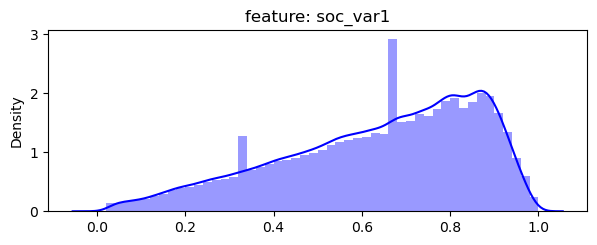

In [ ]:
### visualizacion variables de tipo int

### Definiendo variables a graficar
features = df.drop("id_persona", axis=1).select_dtypes(exclude=[object])

### configuración de area de las gráficas
plt.figure(figsize=(32,32))
gs = gridspec.GridSpec(8, 4)
gs.update(hspace=0.8)

### Graficando las variables
for i, f in enumerate(features):
    ax = plt.subplot(gs[i])
    sns.distplot(df[f], color='b')
    ax.set_xlabel('')
    ax.set_title('feature: ' + str(f))

plt.show()

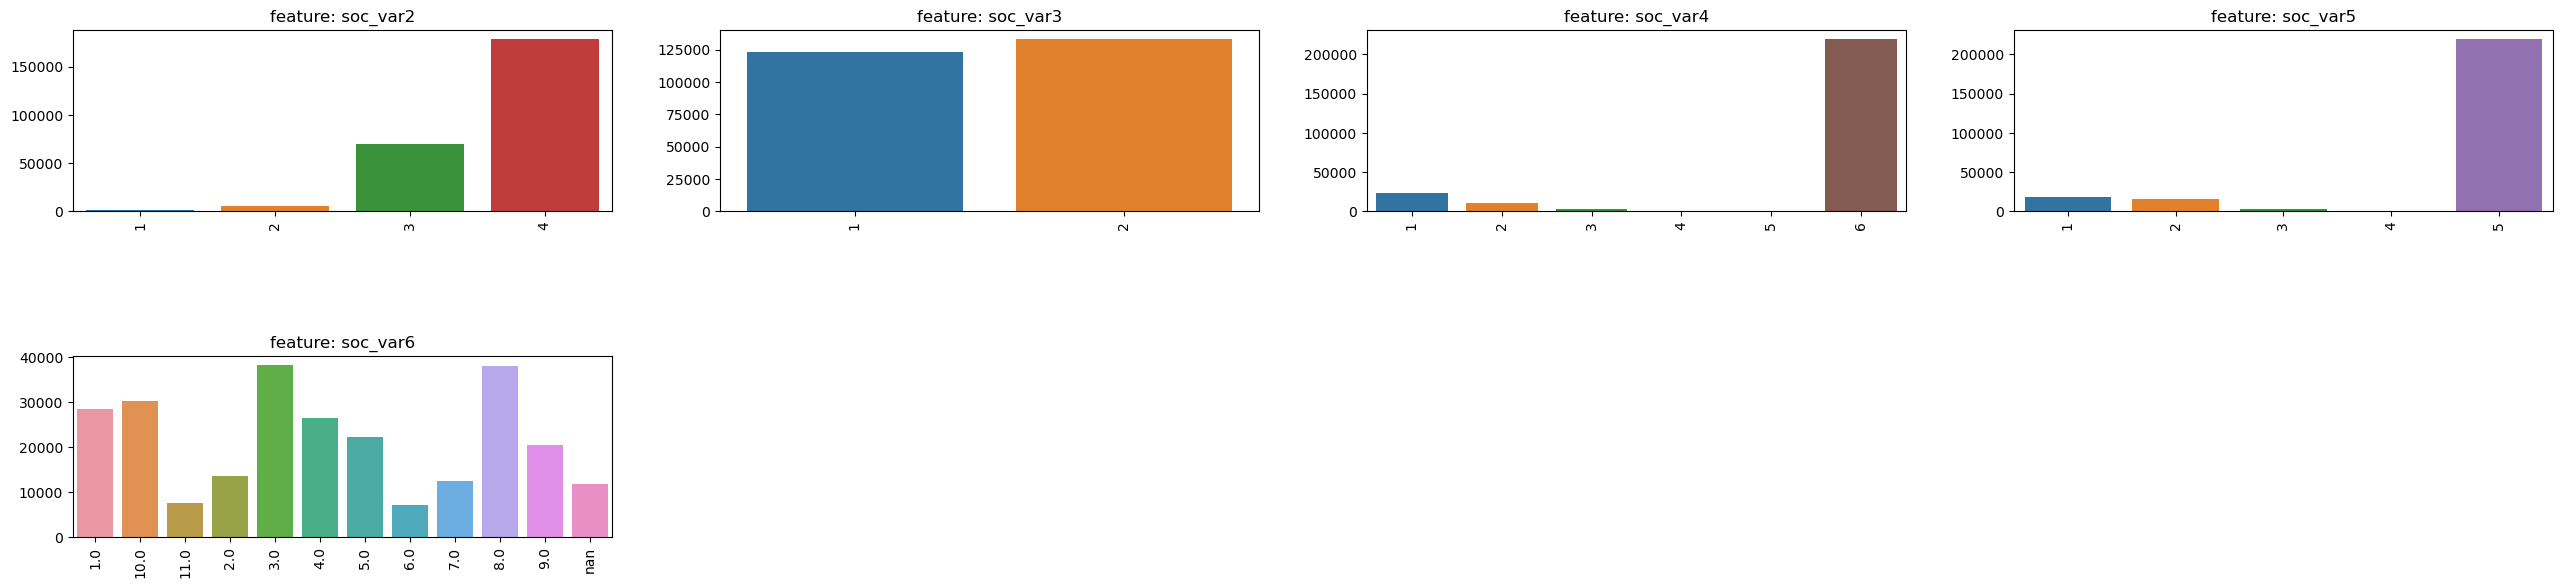

In [ ]:
### visualizacion variables de tipo string

### Definiendo variables a graficar
features = df.drop("id_persona", axis=1).select_dtypes(include=[object]).columns

### configuración de area de las gráficas
plt.figure(figsize=(32,32))
gs = gridspec.GridSpec(8, 4)
gs.update(hspace=0.8)

### Graficando las variables
df["VALOR"]=1
for i, f in enumerate(features):
    ax = plt.subplot(gs[i])
    valor=df.groupby(f)["VALOR"].sum().reset_index()
    #sns.barplot(valor[f],valor["VALOR"])
    sns.barplot(data = valor, x = f, y = "VALOR")
    ax.set_xlabel('')
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    ax.set_ylabel('')
    ax.set_title('feature: ' + str(f))

df.drop("VALOR", axis=1, inplace=True)
plt.show()

### Preparación de los datos

Vamos a procesar la información demográfica para obtener variables que puedan influenciar en el caso de estudio.

In [ ]:
### Artificio para procesar los datos de esta fuente:

### Cargando nuevamente los datos para que todas las variables esten en formato númerico
df_dem = pd.read_csv("ib_base_reniec.csv", sep=",")

### Imputación de las variables que tienen datos nulos
df_dem = replacenullentero(df_dem, "soc_var6")

## informacion sunat

Sunat contiene información de negocios de la persona

#### Cargando los datos

Cargaremos la tabla sunat. El detalle de la información contiene la actividad económica, antiguedad.

In [ ]:
### Cargando informacion SUNAT
df = pd.read_csv('ib_base_sunat.csv')

In [ ]:
print("El numero de filas del dataframe es: ",df.shape[0])

El numero de filas del dataframe es:  196336


In [ ]:
### Primeros 5 lineas del dataframe
df.head()

id_persona activ_econo  meses_alta
0      174454    Grupo_11          70
1      245154    Grupo_15          27
2        1211    Grupo_07          20
3      146154    Grupo_15         135
4       87697    Grupo_07          55

In [ ]:
### Formato de las columnas del dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196336 entries, 0 to 196335
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   id_persona   196336 non-null  int64 
 1   activ_econo  196336 non-null  object
 2   meses_alta   196336 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.5+ MB


#### Exploración de los datos

Revisaremos como esta la información a traves de estadisticas descriptivas de los datos, valores nulos, valores duplicados, visualización de los datos, etc.

In [ ]:
### Estadisticas descriptivas de las variables de tipo int
df.drop("id_persona", axis=1).describe().transpose()

count        mean       std  min   25%   50%    75%    max
meses_alta  196336.0  114.523867  78.50645  1.0  51.0  96.0  163.0  975.0

In [ ]:
### Estadisticas descriptivas de las variables de tipo string
columnas = df.select_dtypes(include=[object]).columns

for value in columnas:
  print("Variable: ", value)
  print(df.groupby(value)["id_persona"].count().reset_index(name='cantidad').sort_values("cantidad", ascending = False))
  print("-------------------------------------------------------------")

Variable:  activ_econo
   activ_econo  cantidad
14    Grupo_15     78075
10    Grupo_11     60443
6     Grupo_07     27763
13    Grupo_14      6789
7     Grupo_08      4904
3     Grupo_04      4873
12    Grupo_13      4801
8     Grupo_09      4372
11    Grupo_12      1913
5     Grupo_06      1112
0     Grupo_01       606
9     Grupo_10       287
2     Grupo_03       174
1     Grupo_02        75
15    Grupo_16        51
4     Grupo_05        49
17       Otros        42
16    Grupo_17         7
-------------------------------------------------------------


In [ ]:
### Valores Duplicados
df[df[['id_persona']].duplicated()].head()

id_persona activ_econo  meses_alta
4385       35197    Grupo_11         175
5099       83011    Grupo_15         258
5794       21437    Grupo_13          39
6361       79724    Grupo_07         173
6812       10071    Grupo_15         293

In [ ]:
### Revisión de datos nulos
df.isna().sum()

id_persona     0
activ_econo    0
meses_alta     0
dtype: int64

C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\1341065401.py:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[f], color='b')


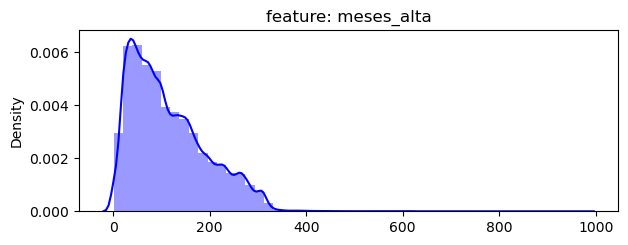

In [ ]:
### visualizacion variables de tipo int

### Definiendo variables a graficar
features = df.drop("id_persona", axis=1).select_dtypes(exclude=[object])

### configuración de area de las gráficas
plt.figure(figsize=(32,32))
gs = gridspec.GridSpec(8, 4)
gs.update(hspace=0.8)

### Graficando las variables
for i, f in enumerate(features):
    ax = plt.subplot(gs[i])
    sns.distplot(df[f], color='b')
    ax.set_xlabel('')
    ax.set_title('feature: ' + str(f))

plt.show()

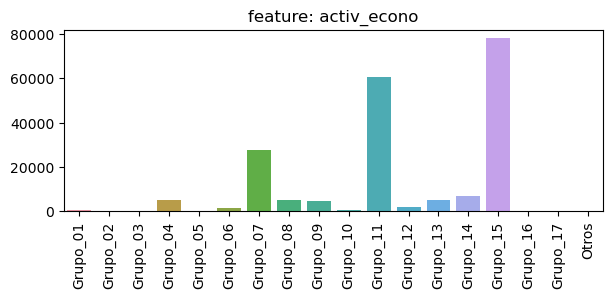

In [ ]:
### visualizacion variables de tipo string

### Definiendo variables a graficar
features = df.drop("id_persona", axis=1).select_dtypes(include=[object]).columns

### configuración de area de las gráficas
plt.figure(figsize=(32,32))
gs = gridspec.GridSpec(8, 4)
gs.update(hspace=0.8)

### Graficando las variables
df["VALOR"]=1
for i, f in enumerate(features):
    ax = plt.subplot(gs[i])
    valor=df.groupby(f)["VALOR"].sum().reset_index()
    #sns.barplot(valor[f],valor["VALOR"])
    sns.barplot(data = valor, x = f, y = "VALOR")
    ax.set_xlabel('')
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    ax.set_ylabel('')
    ax.set_title('feature: ' + str(f))

df.drop("VALOR", axis=1, inplace=True)
plt.show()

#### Preparación de los datos

Preparación de los datos como: Feature Engineering, data processing

In [ ]:
### Agregando variable contador
df['tenencia'] = 1

### Pivoteando la variable meses alta - utilizamos la función tabla_pivot1
df_sunat_pivot_activ_econ_c = tabla_pivot1(df, 'activ_econo', 'meses_alta')
df_sunat_pivot_activ_econ_c = df_sunat_pivot_activ_econ_c.fillna(0)

### Función para calcular frecuencia
def func_num_tenencia(df):
  df_sunat_pivot = tabla_pivot1(df,'activ_econo','tenencia')
  df_sunat_pivot = df_sunat_pivot.fillna(0)

  df_sunat_pivot['num_tenencia_activ_econo'] = df_sunat_pivot[df_sunat_pivot.columns[1:19]].sum(axis=1)
  df_sunat_pivot = df_sunat_pivot[['id_persona','num_tenencia_activ_econo']]
  return df_sunat_pivot

### creando variable frecuencia
df_sunat_pivot_activ_econ_t = func_num_tenencia(df)
df_sunat_pivot_activ_econ_c = df_sunat_pivot_activ_econ_c.merge(df_sunat_pivot_activ_econ_t, how='left', on='id_persona')

In [ ]:
df_sunat_pivot_activ_econ_c.head()

id_persona  meses_alta_grupo_01  meses_alta_grupo_02  meses_alta_grupo_03  \
0           1                  0.0                  0.0                  0.0   
1           3                  0.0                  0.0                  0.0   
2           5                  0.0                  0.0                  0.0   
3           6                  0.0                  0.0                  0.0   
4           9                  0.0                  0.0                  0.0   

   meses_alta_grupo_04  meses_alta_grupo_05  meses_alta_grupo_06  \
0                  0.0                  0.0                  0.0   
1                  0.0                  0.0                  0.0   
2                  0.0                  0.0                  0.0   
3                  0.0                  0.0                  0.0   
4                  0.0                  0.0                  0.0   

   meses_alta_grupo_07  meses_alta_grupo_08  meses_alta_grupo_09  \
0                  0.0                  0.0                  0.0   
1                  0.0                  0.0                  0.0   
2                 46.0                  0.0                  0.0   
3                  0.0                  0.0                  0.0   
4                  0.0                  0.0                  0.0   

   meses_alta_grupo_10  meses_alta_grupo_11  meses_alta_grupo_12  \
0                  0.0                  0.0                  0.0   
1                  0.0                  0.0                  0.0   
2                  0.0                  0.0                  0.0   
3                  0.0                  0.0                  0.0   
4                  0.0                  0.0                  0.0   

   meses_alta_grupo_13  meses_alta_grupo_14  meses_alta_grupo_15  \
0                  0.0                  0.0                273.0   
1                  0.0                  0.0                 30.0   
2                  0.0                  0.0                  0.0   
3                307.0                  0.0                  0.0   
4                159.0                  0.0                  0.0   

   meses_alta_grupo_16  meses_alta_grupo_17  meses_alta_otros  \
0                  0.0                  0.0               0.0   
1                  0.0                  0.0               0.0   
2                  0.0                  0.0               0.0   
3                  0.0                  0.0               0.0   
4                  0.0                  0.0               0.0   

   num_tenencia_activ_econo  
0                       1.0  
1                       1.0  
2                       1.0  
3                       1.0  
4                       1.0

In [ ]:
### podemos ver frecuencia de la variable numero de empresas con actividad economica
df_sunat_pivot_activ_econ_c.groupby("num_tenencia_activ_econo")["id_persona"].count()

num_tenencia_activ_econo
1.0    195976
2.0       177
3.0         2
Name: id_persona, dtype: int64

## Juntando todas las variables

Juntamos todas las tablas creadas: Linea Disponible TC, deuda a nivel banco, deuda a nivel producto, deuda a nivel tipo credito, deuda a nivel riesgo, demografica.

In [ ]:
### Cruzamos nuestro universo de datos con las variables creadas
### Deuda por BANCO
### Deuda por PRODUCTO
### Deuda por CLASIF
### Deuda por RANGO_MORA
### LINEA DISPONIBLE
### DEMOGRAFICAS
df_train = df_income.merge(df_pivot_banco_s6, on=["codmes", "id_persona"], how="inner") \
                    .merge(df_pivot_producto_s6, on=["codmes", "id_persona"], how="inner") \
                    .merge(df_pivot_clasif_s6, on=["codmes", "id_persona"], how="inner") \
                    .merge(df_pivot_rangomora_s6, on=["codmes", "id_persona"], how="inner") \
                    .merge(df_rcc_dif_tc_pivot_banco_s6, on=["codmes", "id_persona"], how="inner") \
                    .merge(df_dem, on=["id_persona"], how="inner")
                    # .merge(df_sunat_pivot_activ_econ_c, on="id_persona", how="left")

df_train = df_train.fillna(0)
df_train["id"] = df_train["codmes"].astype(str) + df_train["id_persona"].astype(str)
df_train = df_train.drop(["codmes", "id_persona"], axis=1).set_index("id")

C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\4290224416.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train["id"] = df_train["codmes"].astype(str) + df_train["id_persona"].astype(str)


In [ ]:
print("El numero de variables es: ", df_train.shape[1])

El numero de variables es:  1273


In [ ]:
df_train.head(5)

ingreso_neto  mto_saldo_total_1  mto_saldo_total_2  \
id                                                                 
201903230317        3007.0          14.560170           7.002893   
201901216964        2115.0          11.644236          12.515250   
201904216964        2004.0           4.247030           5.677279   
201903114204        1122.0           7.246390           7.269651   
201901114204        1122.0           7.472360           6.828227   

              mto_saldo_total_3  mto_saldo_total_4  mto_saldo_total_5  \
id                                                                      
201903230317           7.616276           7.790672           7.936974   
201901216964          19.228907          25.212371          14.768640   
201904216964          11.888297          11.644236          12.515250   
201903114204           7.472360           6.828227           7.059994   
201901114204           7.059994           7.291159           6.118245   

              mto_saldo_total_6  mto_saldo_total_7  mto_saldo_total_8  \
id                                                                      
201903230317           8.063724                0.0                0.0   
201901216964          21.125989                0.0                0.0   
201904216964          19.228907                0.0                0.0   
201903114204           7.291159                0.0                0.0   
201901114204           0.000000                0.0                0.0   

              mto_saldo_total_9  mto_saldo_total_10  mto_saldo_total_11  \
id                                                                        
201903230317                0.0                 0.0                 0.0   
201901216964                0.0                 0.0                 0.0   
201904216964                0.0                 0.0                 0.0   
201903114204                0.0                 0.0                 0.0   
201901114204                0.0                 0.0                 0.0   

              mto_saldo_total_12  mto_saldo_total_prom_3m  \
id                                                          
201903230317                 0.0                 9.726446   
201901216964                 0.0                14.462798   
201904216964                 0.0                 7.270868   
201903114204                 0.0                 7.329467   
201901114204                 0.0                 7.120194   

              mto_saldo_total_prom_6m  mto_saldo_total_prom_9m  \
id                                                               
201903230317                 8.828451                 8.828451   
201901216964                17.415899                17.415899   
201904216964                10.866833                10.866833   
201903114204                 7.194630                 7.194630   
201901114204                 6.953997                 6.953997   

              mto_saldo_total_prom_12m  mto_saldo_total_freq_3m  \
id                                                                
201903230317                  8.828451                        3   
201901216964                 17.415899                        3   
201904216964                 10.866833                        3   
201903114204                  7.194630                        3   
201901114204                  6.953997                        3   

              mto_saldo_total_freq_6m  mto_saldo_total_freq_9m  \
id                                                               
201903230317                        6                        6   
201901216964                        6                        6   
201904216964                        6                        6   
201903114204                        6                        6   
201901114204                        5                        5   

              mto_saldo_total_freq_12m  mto_saldo_total_increm_3m  \
id                                                                  
201903230317             

## Partition train-test

Partición de los datos train para entrenar y test para validar los resultados del modelo

In [ ]:
### partition train-test a traves de la función train_test_split
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(df_train, test_size=0.2, random_state=42)

### Etiquetando variable target
def remove_labels(df, label_name):
    X = df.drop(label_name, axis=1)
    y = df[label_name].copy()
    return (X, y)

### Definiendo las variables: dependiente e independiente
X_train, y_train = remove_labels(train_set,'ingreso_neto')
X_test, y_test = remove_labels(test_set,'ingreso_neto')

print("Los datos de entrenamiento son: ",X_train.shape[0])
print("Los datos de test son: ",X_test.shape[0])
print("El numero de variables es: ", X_train.shape[1])

Los datos de entrenamiento son:  12916
Los datos de test son:  3229
El numero de variables es:  1272


## Selección de Variables

Revisaremos las técnicas de selección mas usadas para saber que variables tienen mayor correlación con el target, es decir que variables son influyentes en la solución del problema.

### Seleccion por RFE

Clasificación de características con eliminación de características recursivas. El objetivo de la eliminación de características recursivas (RFE) es seleccionar características considerando recursivamente conjuntos de características cada vez más pequeños

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

### Definición y entrenamiento del algoritmo
estimator = LinearRegression()
selector = RFE(estimator, n_features_to_select=80, step=200)
selector.fit(X_train, y_train)

### Ordenando las variables por importancia desde la mas importante hasta la menos importante
importance = pd.DataFrame(selector.support_, index=X_train.columns).reset_index()
importance.columns = ["importance_var","value"]
importance[importance["value"]==True]

importance_var  value
54                    mto_saldo_banco16_desv_9m   True
55                   mto_saldo_banco16_desv_12m   True
306                   mto_saldo_banco30_desv_9m   True
307                  mto_saldo_banco30_desv_12m   True
334                   mto_saldo_banco14_desv_9m   True
335                  mto_saldo_banco14_desv_12m   True
362                   mto_saldo_banco29_desv_9m   True
363                  mto_saldo_banco29_desv_12m   True
530    mto_saldo_tarjetasotrosconceptos_desv_9m   True
531   mto_saldo_tarjetasotrosconceptos_desv_12m   True
548        mto_saldo_hipotecarioregular_freq_3m   True
552      mto_saldo_hipotecarioregular_increm_3m   True
553      mto_saldo_hipotecarioregular_increm_6m   True
554      mto_saldo_hipotecarioregular_increm_9m   True
555     mto_saldo_hipotecarioregular_increm_12m   True
557        mto_saldo_hipotecarioregular_desv_6m   True
558        mto_saldo_hipotecarioregular_desv_9m   True
559       mto_saldo_hipotecarioregular_desv_12m   True
585                 mto_saldo_vehicular_desv_6m   True
586                 mto_saldo_vehicular_desv_9m   True
587                mto_saldo_vehicular_desv_12m   True
588           mto_saldo_hipotecariomivivienda_1   True
589           mto_saldo_hipotecariomivivienda_2   True
590           mto_saldo_hipotecariomivivienda_3   True
591           mto_saldo_hipotecariomivivienda_4   True
592           mto_saldo_hipotecariomivivienda_5   True
593           mto_saldo_hipotecariomivivienda_6   True
600     mto_saldo_hipotecariomivivienda_prom_3m   True
604     mto_saldo_hipotecariomivivienda_freq_3m   True
608   mto_saldo_hipotecariomivivienda_increm_3m   True
610   mto_saldo_hipotecariomivivienda_increm_9m   True
611  mto_saldo_hipotecariomivivienda_increm_12m   True
612     mto_saldo_hipotecariomivivienda_desv_3m   True
613     mto_saldo_hipotecariomivivienda_desv_6m   True
614     mto_saldo_hipotecariomivivienda_desv_9m   True
615    mto_saldo_hipotecariomivivienda_desv_12m   True
641                   mto_saldo_restord_desv_6m   True
642                   mto_saldo_restord_desv_9m   True
643                  mto_saldo_restord_desv_12m   True
645            mto_saldo_tarjetaempsindefinir_2   True
646            mto_saldo_tarjetaempsindefinir_3   True
647            mto_saldo_tarjetaempsindefinir_4   True
648            mto_saldo_tarjetaempsindefinir_5   True
649            mto_saldo_tarjetaempsindefinir_6   True
660      mto_saldo_tarjetaempsindefinir_freq_3m   True
665    mto_saldo_tarjetaempsindefinir_increm_6m   True
666    mto_saldo_tarjetaempsindefinir_increm_9m   True
667   mto_saldo_tarjetaempsindefinir_increm_12m   True
669      mto_saldo_tarjetaempsindefinir_desv_6m   True
670      mto_saldo_tarjetaempsindefinir_desv_9m   True
671     mto_saldo_tarjetaempsindefinir_desv_12m   True
716        mto_saldo_tarjetaempefectivo_freq_3m   True
720      mto_saldo_tarjetaempefectivo_increm_3m   True
721      mto_saldo_tarjetaempefectivo_increm_6m   True
722      mto_saldo_tarjetaempefectivo_increm_9m   True
723     mto_saldo_tarjetaempefectivo_increm_12m   True
725        mto_saldo_tarjetaempefectivo_desv_6m   True
726        mto_saldo_tarjetaempefectivo_desv_9m   True
727       mto_saldo_tarjetaempefectivo_desv_12m   True
728                   mto_saldo_otroscreditos_1   True
729                   mto_saldo_otroscreditos_2   True
730                   mto_saldo_otroscreditos_3   True
731                   mto_saldo_otroscreditos_4   True
732                   mto_saldo_otroscreditos_5   True
733                   mto_saldo_otroscreditos_6   True
740             mto_saldo_otroscreditos_prom_3m   True
741             mto_saldo_otroscreditos_prom_6m   True
742             mto_saldo_otroscreditos_prom_9m   True
743            mto_saldo_otroscreditos_prom_12m   True
744             mto_saldo_otroscreditos_freq_3m   True
748           mto_saldo_otroscreditos_increm_3m   True
749           mto_saldo_otroscreditos_increm_6m   True
753             mt

In [ ]:
### Selección de las variables mas importantes TOP 80 variables
features = list(importance[importance["value"]==True]["importance_var"])

### Correlación

La selección por correlación nos indica la relación lineal de las variables con el target, mientras mayor sea el valor mayor importancia tiene la variables

In [ ]:
### Correlación de variables
corrmat = df_train.corr()

### Ordenando las variables por correlacion desde la mas importante hasta la menos importante
relevant_features = corrmat["ingreso_neto"].reset_index()
relevant_features = relevant_features[relevant_features["index"]!="ingreso_neto"]
relevant_features = relevant_features.sort_values("ingreso_neto", ascending=False)

In [ ]:
corrmat["ingreso_neto"].reset_index().head(4)

index  ingreso_neto
0       ingreso_neto      1.000000
1  mto_saldo_total_1      0.217536
2  mto_saldo_total_2      0.227126
3  mto_saldo_total_3      0.227166

In [ ]:
relevant_features.head(5)

index  ingreso_neto
560  mto_saldo_hipotecarioregular_desv_12m      0.393517
559   mto_saldo_hipotecarioregular_desv_9m      0.393275
546   mto_saldo_hipotecarioregular_prom_6m      0.392619
547   mto_saldo_hipotecarioregular_prom_9m      0.392619
548  mto_saldo_hipotecarioregular_prom_12m      0.392619

In [ ]:
### Maneras de seleccionar el TOP mas importante de variables:

### seleccionado las variables con un umbral (2%)
features = list(relevant_features[relevant_features["ingreso_neto"]>=0.02]["index"])

### seleccionado las variables con un umbral (entre 2% y 60%)
features = list(relevant_features[(relevant_features["ingreso_neto"]>=0.02) & (relevant_features["ingreso_neto"]<=0.6)]["index"])

In [ ]:
### Selección de las variables mas correlacionadas TOP 80 variables
features = list(relevant_features["index"][:80])

In [ ]:
relevant_features

index  ingreso_neto
560         mto_saldo_hipotecarioregular_desv_12m      0.393517
559          mto_saldo_hipotecarioregular_desv_9m      0.393275
546          mto_saldo_hipotecarioregular_prom_6m      0.392619
547          mto_saldo_hipotecarioregular_prom_9m      0.392619
548         mto_saldo_hipotecarioregular_prom_12m      0.392619
538                mto_saldo_hipotecarioregular_6      0.390950
558          mto_saldo_hipotecarioregular_desv_6m      0.388652
545          mto_saldo_hipotecarioregular_prom_3m      0.386100
535                mto_saldo_hipotecarioregular_3      0.385968
536                mto_saldo_hipotecarioregular_4      0.385842
537                mto_saldo_hipotecarioregular_5      0.384734
534                mto_saldo_hipotecarioregular_2      0.384252
533                mto_saldo_hipotecarioregular_1      0.381783
552         mto_saldo_hipotecarioregular_freq_12m      0.380241
551          mto_saldo_hipotecarioregular_freq_9m      0.380241
550          mto_saldo_hipotecarioregular_freq_6m      0.380241
549          mto_saldo_hipotecarioregular_freq_3m      0.374718
555        mto_saldo_hipotecarioregular_increm_9m      0.370382
556       mto_saldo_hipotecarioregular_increm_12m      0.370382
56                     mto_saldo_banco16_desv_12m      0.267628
44                     mto_saldo_banco16_prom_12m      0.266958
43                      mto_saldo_banco16_prom_9m      0.266958
42                      mto_saldo_banco16_prom_6m      0.266958
55                      mto_saldo_banco16_desv_9m      0.266727
34                            mto_saldo_banco16_6      0.265421
33                            mto_saldo_banco16_5      0.262860
41                      mto_saldo_banco16_prom_3m      0.261094
31                            mto_saldo_banco16_3      0.260284
54                      mto_saldo_banco16_desv_6m      0.259323
32                            mto_saldo_banco16_4      0.257399
30                            mto_saldo_banco16_2      0.257332
29                            mto_saldo_banco16_1      0.257111
26                        mto_saldo_total_desv_6m      0.246469
27                        mto_saldo_total_desv_9m      0.244102
28                       mto_saldo_total_desv_12m      0.243353
792                   mto_saldo_clasif0.0_prom_6m      0.241625
14                        mto_saldo_total_prom_6m      0.241284
15                        mto_saldo_total_prom_9m      0.241284
16                       mto_saldo_total_prom_12m      0.241284
812                mto_saldo_rangomora1.0_prom_6m      0.239860
5                               mto_saldo_total_5      0.232673
789                         mto_saldo_clasif0.0_5      0.231930
791                   mto_saldo_clasif0.0_prom_3m      0.231343
13                        mto_saldo_total_prom_3m      0.230992
809                      mto_saldo_rangomora1.0_5      0.230561
790                         mto_saldo_clasif0.0_6      0.229981
4                               mto_saldo_total_4      0.228568
810                      mto_saldo_rangomora1.0_6      0.228491
811                mto_saldo_rangomora1.0_prom_3m      0.228479
6                               mto_saldo_total_6      0.228338
3                               mto_saldo_total_3      0.227166
2                               mto_saldo_total_2      0.227126
787                         mto_saldo_clasif0.0_3      0.226577
788                         mto_saldo_clasif0.0_4      0.226432
786                         mto_saldo_clasif0.0_2      0.226243
808                      mto_saldo_rangomora1.0_4      0.226132
807                      mto_saldo_rangomora1.0_3      0.223469
806                      mto_saldo_rangomora1.0_2      0.222833
785                         mto_saldo_clasif0.0_1      0.218008
1                               mto_saldo_total_1      0.217536
805                      mto_saldo_rangomora1.0_1      0.215616
1118                      saldo_diftc_16_freq_12m      0.194821
48          

### Utilizando el Algoritmo RandomForest

El algoritmo randomforest internamente tiene una potente selección de variables por importancia con respecto al target. Utilizaremos esta selección entrenando los datos con 500 arboles

In [ ]:
from sklearn.ensemble import RandomForestRegressor

### Definición y entrenamiento del algoritmo con 500 arboles
selection = RandomForestRegressor(n_estimators=500, random_state=4242)
selection.fit(X_train, y_train)

RandomForestRegressor(n_estimators=500, random_state=4242)

In [ ]:
### Ordenando las variables por importancia desde la mas importante hasta la menos importante
importance_1 = pd.DataFrame(selection.feature_importances_, index=X_train.columns).reset_index()
importance_1.columns = ["index","value"]
importance_1 = importance_1.sort_values('value',ascending=False)

In [ ]:
importance_1.head(5)

index     value
996                       saldo_diftc_52_11  0.046674
1270                               soc_var5  0.042134
537          mto_saldo_hipotecarioregular_6  0.032915
546    mto_saldo_hipotecarioregular_prom_9m  0.028621
547   mto_saldo_hipotecarioregular_prom_12m  0.028339

In [ ]:
# importance_1.to_csv("/content/drive/My Drive/cursos/python-for-data-science/python-machine-learning/machine-learning-for-bank/04-income/importance.csv", index=False)

In [ ]:
#importance_1=importance_1.reset_index()

importance_1

### Maneras de seleccionar el TOP mas importante de variables:

### seleccionado las variables con un umbral (1%)
features = list(importance_1[importance_1["value"]>=0.01]["index"])

### seleccionado las variables con un umbral (entre 1% y 5%)
#features = list(importance_1[(importance_1["value"]>=0.01) & (relevant_features["ingreso_neto"]<=0.05)]["index"])

list(importance_1.sort_values('value',ascending=False)['index'].head(80))

In [ ]:
### Cargando la importancia de variables
#importance_1 = pd.read_csv("/content/drive/My Drive/cursos/python-for-data-science/python-machine-learning/machine-learning-for-bank/04-income/importance.csv")

### Selección de las variables mas importantes TOP 80 variables
features = list(importance_1.sort_values('value',ascending=False)['index'].head(80))

In [ ]:
features

['saldo_diftc_52_11',
 'soc_var5',
 'mto_saldo_hipotecarioregular_6',
 'mto_saldo_hipotecarioregular_prom_9m',
 'mto_saldo_hipotecarioregular_prom_12m',
 'mto_saldo_hipotecarioregular_desv_12m',
 'mto_saldo_hipotecarioregular_prom_6m',
 'mto_saldo_hipotecarioregular_desv_9m',
 'soc_var1',
 'mto_saldo_prestamoscomerciales_6',
 'mto_saldo_hipotecarioregular_desv_6m',
 'mto_saldo_tarjetaempsindefinir_2',
 'mto_saldo_banco16_6',
 'mto_saldo_prestamoscomerciales_4',
 'mto_saldo_hipotecarioregular_3',
 'mto_saldo_hipotecarioregular_2',
 'mto_saldo_tarjetaempsindefinir_5',
 'mto_saldo_hipotecarioregular_increm_6m',
 'mto_saldo_banco16_desv_6m',
 'mto_saldo_total_desv_6m',
 'saldo_diftc_16_desv_3m',
 'saldo_diftc_17_prom_6m',
 'mto_saldo_prestamoscomerciales_5',
 'mto_saldo_tarjetascompras_2',
 'saldo_diftc_17_prom_9m',
 'mto_saldo_prestamoscomerciales_3',
 'saldo_diftc_66_12',
 'mto_saldo_tarjetaempsindefinir_3',
 'saldo_diftc_17_prom_12m',
 'mto_saldo_tarjetascompras_1',
 'mto_saldo_banco16_

### Filtrando las variables finales

In [ ]:
### TOP 80 variables mas importantes por selección de variables
X_trainf = X_train[features]
X_testf  = X_test[features]

In [ ]:
X_trainf.head()

saldo_diftc_52_11  soc_var5  mto_saldo_hipotecarioregular_6  \
id                                                                          
201903191692                0.0         5                        0.000000   
201903171990                0.0         5                        0.000000   
201903107576                0.0         1                       11.793394   
20190475046                 0.0         5                        0.000000   
20190240049                 0.0         5                        0.000000   

              mto_saldo_hipotecarioregular_prom_9m  \
id                                                   
201903191692                              0.000000   
201903171990                              0.000000   
201903107576                             11.784128   
20190475046                               0.000000   
20190240049                               0.000000   

              mto_saldo_hipotecarioregular_prom_12m  \
id                                                    
201903191692                               0.000000   
201903171990                               0.000000   
201903107576                              11.784128   
20190475046                                0.000000   
20190240049                                0.000000   

              mto_saldo_hipotecarioregular_desv_12m  \
id                                                    
201903191692                               0.000000   
201903171990                               0.000000   
201903107576                               6.068854   
20190475046                                0.000000   
20190240049                                0.000000   

              mto_saldo_hipotecarioregular_prom_6m  \
id                                                   
201903191692                              0.000000   
201903171990                              0.000000   
201903107576                             11.784128   
20190475046                               0.000000   
20190240049                               0.000000   

              mto_saldo_hipotecarioregular_desv_9m  soc_var1  \
id                                                             
201903191692                               0.00000  0.830189   
201903171990                               0.00000  0.792453   
201903107576                               6.21167  0.641509   
20190475046                                0.00000  0.603774   
20190240049                                0.00000  0.490566   

              mto_saldo_prestamoscomerciales_6  \
id                                               
201903191692                           0.00000   
201903171990                           0.00000   
201903107576                           0.00000   
20190475046                            0.00000   
20190240049                            7.96421   

              mto_saldo_hipotecarioregular_desv_6m  \
id                                                   
201903191692                              0.000000   
201903171990                              0.000000   
201903107576                              4.811542   
20190475046                               0.000000   
20190240049                               0.000000   

              mto_saldo_tarjetaempsindefinir_2  mto_saldo_banco16_6  \
id                                                                    
201903191692                               0.0             9.646588   
201903171990                               0.0             0.000000   
201903107576                               0.0             6.859462   
20190475046                                0.0             8.383056   
20190240049                                0.0             0.000000   

              mto_saldo_prestamoscomerciales_4  \
id                                               
201903191692                          0.000000   
201903171990                          0.000000   
201903107576                          0.000000   
20190475046      

## Modeling

Entrenamiento de diferentes modelos, con la finalidad de estimar el caso de estudio, es decir cual es el ingreso de las personas. Asimismo, utilizaremos las diferentes métricas que existen para elegir el mejor modelo que se ajuste a los datos.

### Arboles de Desición, Arboles de Regresión

Un árbol de decisión es un modelo predictivo que divide el espacio de los predictores agrupando observaciones con valores similares para la variable respuesta o dependiente.

Para dividir el espacio muestral en sub-regiones es preciso aplicar una serie de reglas o decisiones, para que cada sub-región contenga la mayor proporción posible de individuos similares.

Si una sub-región contiene datos de diferentes clases, se subdivide en regiones más pequeñas hasta fragmentar el espacio en sub-regiones menores que integran datos similares.

Ventajas:
- Son fáciles de construir, interpretar y visualizar.
- Selecciona las variables más importantes y en su creación no siempre se hace uso de todos los predictores.
- Sirven tanto para variables dependientes cualitativas como cuantitativas.

Desventajas:
- Tienden al sobreajuste u overfitting de los datos, por lo que el modelo al predecir nuevos casos no estima con el mismo índice de acierto.
- Crear árboles demasiado complejos puede conllevar que no se adapten bien a los nuevos datos. La complejidad resta capacidad de interpretación.

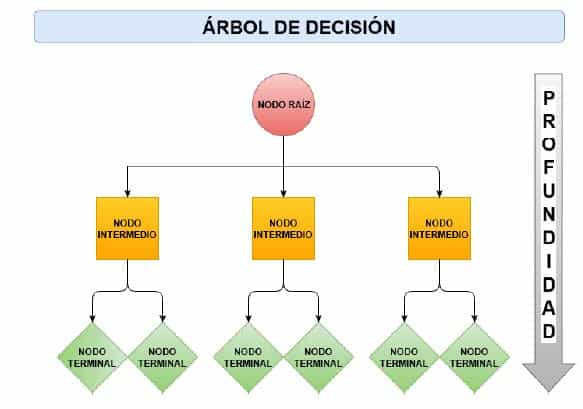

In [ ]:
from sklearn.tree import DecisionTreeRegressor

### Configuración del algoritmo
model_dt = DecisionTreeRegressor(random_state=4242)

### Entrenamiento del algortimo sobre los datos TRAIN
model_dt.fit(X_trainf, y_train)

DecisionTreeRegressor(random_state=4242)

In [ ]:
### Predicción de los datos TEST utilizando el algoritmo entrenado
y_pred = model_dt.predict(X_testf)

### guardando los resultados en el dataframe TEST
test_set['ingreso_neto_predS'] = y_pred

C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\2021187411.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_set['ingreso_neto_predS'] = y_pred


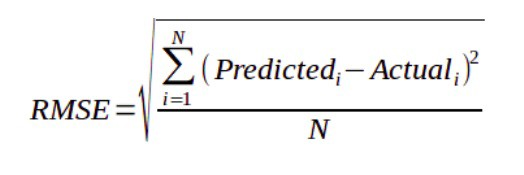

In [ ]:
### SELECCION POR STEP-WASE

### Error Cuadratico Medio
from sklearn.metrics import mean_squared_error
print(mean_squared_error(y_test, y_pred))

7553123.992257665


In [ ]:
### SELECCION POR CORRELACION

### Error Cuadratico Medio
from sklearn.metrics import mean_squared_error
print(mean_squared_error(y_test, y_pred))

7553123.992257665


In [ ]:
### SELECCION POR RANDOMFOREST

### Error Cuadratico Medio
from sklearn.metrics import mean_squared_error
print(mean_squared_error(y_test, y_pred))

7553123.992257665


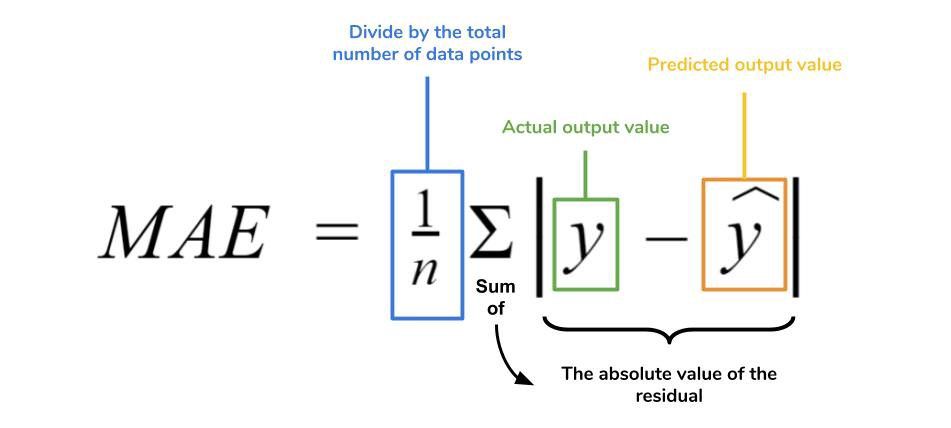

In [ ]:
### Promedio del Error Absoluto (MAE)
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(y_test, y_pred))

1340.4258284298544


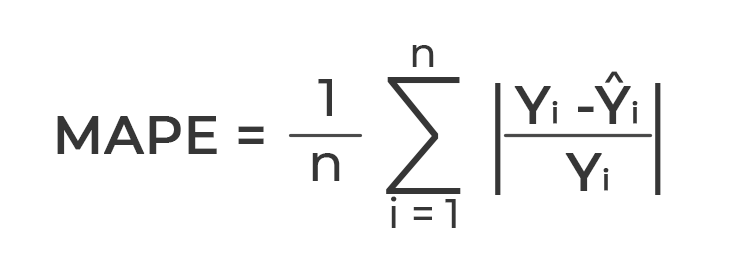

In [ ]:
### Promedio del Porcentaje Error Absoluto (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(mean_absolute_percentage_error(y_test, y_pred))

42.71663676129016


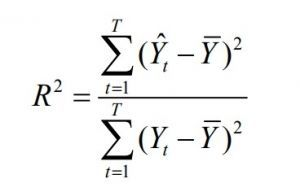

In [ ]:
### R Score
from sklearn.metrics import r2_score
print(r2_score(y_test, y_pred))

-0.038997006650755006


### Regresion Lineal

la regresión lineal o ajuste lineal es un modelo matemático usado para aproximar la relación de dependencia entre una variable dependiente y variables independientes.

Este modelo puede ser expresado en una ecuación:
$$ Y = \beta0 + \beta1*X1 + \beta2*X2 + ... + \beta n*Xn $$

donde:

- Y es la variable dependiente o variable de respuesta.
- X1, X2, ..., Xn son las variables explicativas, independientes o regresoras.
- $\beta0, \beta1, \beta2, ..., \beta n$ son los parámetros del modelo.

Una vez que se ha ajustado un modelo es necesario verificar su eficiencia, ya que aun siendo la línea que mejor se ajusta a las observaciones de entre todas las posibles, el modelo puede ser malo. Las medidas más utilizadas para medir la calidad del ajuste son: error estándar de los residuos, el test F y el coeficiente de determinación R2.

**Condiciones del Modelo:**

- Linealidad: La relación entre ambas variables debe ser lineal.
- Distribución Normal de los residuos: Los residuos se tiene que distribuir de forma normal, con media igual a 0.
- Varianza de residuos constante (homocedasticidad): La varianza de los residuos ha de ser aproximadamente constante a lo largo del eje X.
- Valores atípicos y de alta influencia: Hay que estudiar con detenimiento los valores atípicos o extremos ya que pueden generar una falsa correlación que realmente no existe, u ocultar una existente.
- Independencia, Autocorrelación: Las observaciones deben ser independientes unas de otras.

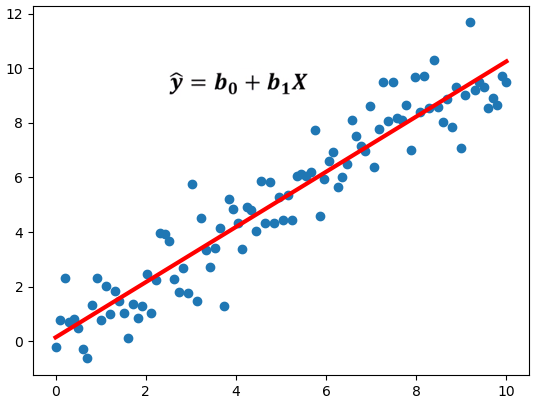

In [ ]:
from sklearn.linear_model import LinearRegression

model_lr = LinearRegression()
model_lr.fit(X_trainf, y_train)

LinearRegression()

**Prediciendo el modelo**

In [ ]:
y_pred = model_lr.predict(X_testf)
test_set['ingreso_neto_predS'] = y_pred

**Metricas**

In [ ]:
### Error Cuadratico Medio
from sklearn.metrics import mean_squared_error
print(mean_squared_error(y_test, y_pred))

5140253.033765308


In [ ]:
### Promedio del Error Absoluto (MAE)
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(y_test, y_pred))

1143.207622044532


In [ ]:
### Promedio del Porcentaje Error Absoluto (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(mean_absolute_percentage_error(y_test, y_pred))

36.93645159835801


In [ ]:
### R Score
from sklearn.metrics import r2_score
print(r2_score(y_test, y_pred))

0.2929140947528317


### Ranfom Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

### Configuración del algoritmo
model_rf = RandomForestRegressor(random_state=4242)

### Entrenamiento del algortimo sobre los datos TRAIN
model_rf.fit(X_trainf, y_train)

RandomForestRegressor(random_state=4242)

In [ ]:
### Predicción de los datos TEST utilizando el algoritmo entrenado
y_pred = model_rf.predict(X_testf)

### guardando los resultados en el dataframe TEST
test_set['ingreso_neto_predS'] = y_pred

In [ ]:
### Error Cuadratico Medio
from sklearn.metrics import mean_squared_error
print(mean_squared_error(y_test, y_pred))

4695198.645615268


In [ ]:
### Promedio del Error Absoluto (MAE)
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(y_test, y_pred))

998.493858779808


In [ ]:
### Promedio del Porcentaje Error Absoluto (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(mean_absolute_percentage_error(y_test, y_pred))

32.31924957653184


In [ ]:
### R Score
from sklearn.metrics import r2_score
print(r2_score(y_test, y_pred))

0.354135144156849


### Gradient Boosting Machine

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

### Configuración del algoritmo
model_gbm = GradientBoostingRegressor(random_state=4242)

### Entrenamiento del algortimo sobre los datos TRAIN
model_gbm.fit(X_trainf, y_train)

GradientBoostingRegressor(random_state=4242)

In [ ]:
### Predicción de los datos TEST utilizando el algoritmo entrenado
y_pred = model_gbm.predict(X_testf)

### guardando los resultados en el dataframe TEST
test_set['ingreso_neto_predS'] = y_pred

In [ ]:
### Error Cuadratico Medio
from sklearn.metrics import mean_squared_error
print(mean_squared_error(y_test, y_pred))

4720319.3538978705


In [ ]:
### Promedio del Error Absoluto (MAE)
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(y_test, y_pred))

1049.787321864425


In [ ]:
### Promedio del Porcentaje Error Absoluto (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(mean_absolute_percentage_error(y_test, y_pred))

34.384693044464974


In [ ]:
### R Score
from sklearn.metrics import r2_score
print(r2_score(y_test, y_pred))

0.35067957521116166


### XGBoost


pip install xgboost

In [ ]:
from xgboost import XGBRegressor

### Configuración del algoritmo
model_xgb = XGBRegressor(random_state=4242)

### Entrenamiento del algortimo sobre los datos TRAIN
model_xgb.fit(X_trainf, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=4242, ...)

In [ ]:
### Predicción de los datos TEST utilizando el algoritmo entrenado
y_pred = model_xgb.predict(X_testf)

### guardando los resultados en el dataframe TEST
test_set['ingreso_neto_predS'] = y_pred

In [ ]:
### Error Cuadratico Medio
from sklearn.metrics import mean_squared_error
print(mean_squared_error(y_test, y_pred))

4538885.46043349


In [ ]:
### Promedio del Error Absoluto (MAE)
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(y_test, y_pred))

1012.8073763358552


In [ ]:
### Promedio del Porcentaje Error Absoluto (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(mean_absolute_percentage_error(y_test, y_pred))

32.6284611693011


In [ ]:
### R Score
from sklearn.metrics import r2_score
print(r2_score(y_test, y_pred))

0.37563736385698765


### Tunning de Parametros

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

def gridSerachModels(model,param,X_train,y_train):
  clf_model = RandomizedSearchCV(model, param_distributions=param, scoring="neg_mean_squared_error", cv=5, return_train_score=True)
  # Fit will test all of the combinations
  clf_model.fit(X_train, y_train)
  # Best estimator and best parameters
  print("-----------------------------------------------------------------------")
  print("Los parametros optimizados son: ", clf_model.best_params_)
  print("-----------------------------------------------------------------------")
  print("La métrica en el entrenamiento es: ", clf_model.best_score_)
  return clf_model

### TRAIN
param = {'max_depth':[1, 3, 5], 'n_estimators':range(300, 1200, 300), 'learning_rate':[i/100 for i in range(3,12,3)]}
model_xgb_tun = gridSerachModels(XGBRegressor(), param, X_trainf, y_train)

-----------------------------------------------------------------------
Los parametros optimizados son:  {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.09}
-----------------------------------------------------------------------
La métrica en el entrenamiento es:  -3324300.8321045586


In [ ]:
from xgboost import XGBRegressor

model_xgb_tun = XGBRegressor(n_estimators=300, max_depth=5, learning_rate=0.09, random_state=4242)
model_xgb_tun.fit(X_trainf, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.09, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=4242, ...)

**Aplicar validación cruzada con los parametros Óptimos**

In [ ]:
### Predicción de los datos TEST utilizando el algoritmo entrenado
y_pred = model_xgb_tun.predict(X_testf)

### guardando los resultados en el dataframe TEST
test_set['ingreso_neto_predS'] = y_pred

In [ ]:
### Error Cuadratico Medio
from sklearn.metrics import mean_squared_error
print(mean_squared_error(y_test, y_pred))

4184032.565001669


In [ ]:
### Promedio del Error Absoluto (MAE)
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(y_test, y_pred))

988.0956158725128


In [ ]:
### Promedio del Porcentaje Error Absoluto (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(mean_absolute_percentage_error(y_test, y_pred))

32.11600414389898


In [ ]:
### R Score
from sklearn.metrics import r2_score
print(r2_score(y_test, y_pred))

0.42445042406001654


## Ensanble Models

### Voting de Modelos

Podemos entrenar varios modelos de aprendizaje automático con los mismos datos. Cuando tengamos datos nuevos, obtendremos una predicción de cada modelo. Cada modelo tendrá asociado un voto. De esta forma, propondremos como predicción final lo que voten la mayoría de los modelos.

Hay otra forma de combinar las votaciones. Cuando los modelos de machine learning dan una probabilidad, podemos usar el «voto suave» (soft-voting). En el voto suave, se le da más importancia a los resultados en los que algún modelo esté muy seguro. Es decir, cuando la predicción está muy cercana a la probabilidad 0 ó a 1, se le da más peso a la predicción de ese modelo.

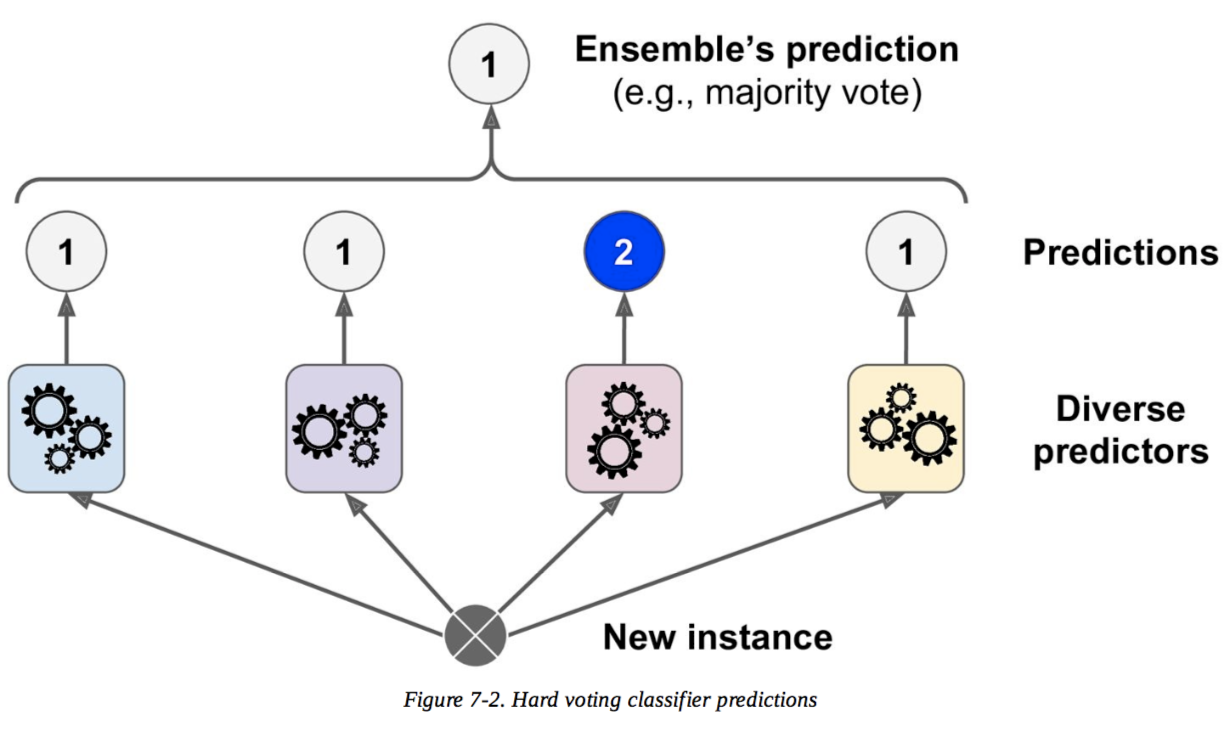

In [ ]:
from sklearn.ensemble import VotingRegressor

### Configuración Ensamblador - utilizamos randomforest y GBM
models = [('lr',RandomForestRegressor()),('dt',GradientBoostingRegressor())]
modelvoting = VotingRegressor(estimators=models)

### Entrenamiento del ensamblador sobre los datos TRAIN
modelvoting.fit(X_trainf, y_train)

VotingRegressor(estimators=[('lr', RandomForestRegressor()),
                            ('dt', GradientBoostingRegressor())])

In [ ]:
### Predicción de los datos TEST utilizando el algoritmo entrenado
y_pred = modelvoting.predict(X_testf)

### guardando los resultados en el dataframe TEST
test_set['ingreso_neto_predS'] = y_pred

In [ ]:
### Error Cuadratico Medio
from sklearn.metrics import mean_squared_error
print(mean_squared_error(y_test, y_pred))

4570167.764742471


In [ ]:
### Promedio del Error Absoluto (MAE)
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(y_test, y_pred))

1006.169531046134


In [ ]:
### Promedio del Porcentaje Error Absoluto (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(mean_absolute_percentage_error(y_test, y_pred))

32.818273380081564


In [ ]:
### R Score
from sklearn.metrics import r2_score
print(r2_score(y_test, y_pred))

0.37133421451487625


### Stacking de Modelos

Cuando hablamos de un ensemble de stacking, nos referimos a que estamos apilando modelos. Cuando apilamos modelos, lo que en realidad estamos haciendo, es usar la salida de varios modelos como la entrada de varios modelos.

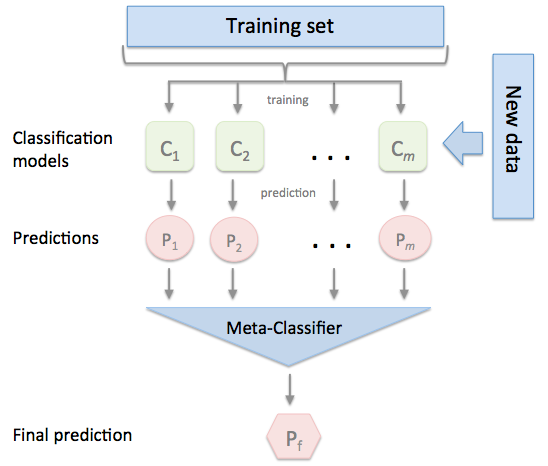

In [ ]:
from sklearn.ensemble import StackingRegressor

### Configuración Ensamblador - utilizamos randomforest y GBM
models = [('model_rf', RandomForestRegressor()), ('model_gbm', GradientBoostingRegressor())]
modelstacking = StackingRegressor(estimators=models, final_estimator=XGBRegressor(), cv=10)

### Entrenamiento del ensamblador sobre los datos TRAIN
modelstacking.fit(X_trainf, y_train)

StackingRegressor(cv=10,
                  estimators=[('model_rf', RandomForestRegressor()),
                              ('model_gbm', GradientBoostingRegressor())],
                  final_estimator=XGBRegressor(base_score=None, booster=None,
                                               callbacks=None,
                                               colsample_bylevel=None,
                                               colsample_bynode=None,
                                               colsample_bytree=None,
                                               device=None,
                                               early_stopping_rounds=None,
                                               enable_categorical=False,
                                               eval_metric=None,
                                               feature_types...
                                               grow_policy=None,
                                               importance_type=None,
                                               interaction_constraints=None,
                                               learning_rate=None, max_bin=None,
                                               max_cat_threshold=None,
                                               max_cat_to_onehot=None,
                                               max_delta_step=None,
                                               max_depth=None, max_leaves=None,
                                               min_child_weight=None,
                                               missing=nan,
                                               monotone_constraints=None,
                                               multi_strategy=None,
                                               n_estimators=None, n_jobs=None,
                                               num_parallel_tree=None,
                                               random_state=None, ...))

In [ ]:
### Predicción de los datos TEST utilizando el algoritmo entrenado
y_pred = modelstacking.predict(X_testf)

### guardando los resultados en el dataframe TEST
test_set['ingreso_neto_predS'] = y_pred

In [ ]:
### Error Cuadratico Medio
from sklearn.metrics import mean_squared_error
print(mean_squared_error(y_test, y_pred))

4606770.659424105


In [ ]:
### Promedio del Error Absoluto (MAE)
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(y_test, y_pred))

1025.5711794298254


In [ ]:
### Promedio del Porcentaje Error Absoluto (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(mean_absolute_percentage_error(y_test, y_pred))

32.326274485838354


In [ ]:
### R Score
from sklearn.metrics import r2_score
print(r2_score(y_test, y_pred))

0.3662991723193617


## Relacion ingreso real vs ingreso pred

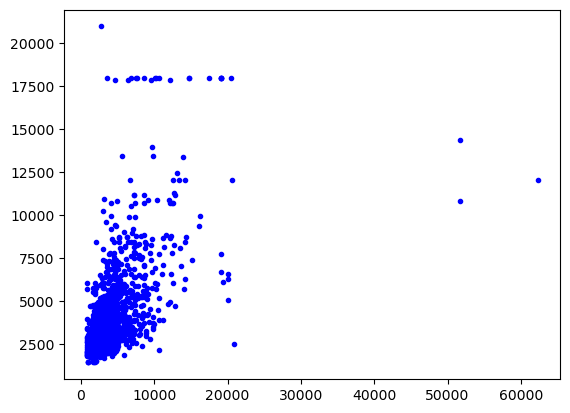

In [ ]:
### Grafico de relación lineal entre ingreso neto vs ingreso estimado
plt.scatter((test_set["ingreso_neto"]), test_set["ingreso_neto_predS"], c="b", marker=".");

In [ ]:
### Error de estimacion - Porcentual
valor_real = 1000
valor_estimado = 800

Indicador = (1000-800)/1000*100
Indicador

20.0

In [ ]:
### Construyendo un indicador de medición de la calidad de estimacion del algoritmo, Métrica similar a MAPE
test_set['diferencia_ingreso_real_pred'] = test_set['ingreso_neto'] - test_set['ingreso_neto_predS']
test_set['porcentaje_erro_real'] = np.round(test_set['diferencia_ingreso_real_pred'] / test_set['ingreso_neto'],4)

### Calculando las categorias de este indicador
test_set.loc[(test_set['porcentaje_erro_real']<=-0.5),'rango_diferencia'] = '1.sobreestimacion mayor igual 50%'
test_set.loc[(test_set['porcentaje_erro_real']>-0.5) & (test_set['porcentaje_erro_real']<=-0.2),'rango_diferencia'] = '2.sobreestimacion entre 50% y 20%'
test_set.loc[(test_set['porcentaje_erro_real']>-0.2) & (test_set['porcentaje_erro_real']<=-0.1),'rango_diferencia'] = '3.sobreestimacion entre 20% y 10%'
test_set.loc[(test_set['porcentaje_erro_real']>-0.1) & (test_set['porcentaje_erro_real']<0),'rango_diferencia'] = '4.sobreestimacion entre 10% y 0%'
test_set.loc[(test_set['porcentaje_erro_real']==0),'rango_diferencia'] = '5.estimacion igual'
test_set.loc[(test_set['porcentaje_erro_real']>0) & (test_set['porcentaje_erro_real']<=0.1),'rango_diferencia'] = '6.subestimacion entre 10% y 0%'
test_set.loc[(test_set['porcentaje_erro_real']>0.1) & (test_set['porcentaje_erro_real']<=0.2),'rango_diferencia'] = '7.subestimacion entre 10% y 20%'
test_set.loc[(test_set['porcentaje_erro_real']>0.2) & (test_set['porcentaje_erro_real']<=0.5),'rango_diferencia'] = '8.subestimacion entre 20% y 50%'
test_set.loc[(test_set['porcentaje_erro_real']>0.5),'rango_diferencia'] = '9.subestimacion mayor a 50%'

C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\2896101435.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_set['diferencia_ingreso_real_pred'] = test_set['ingreso_neto'] - test_set['ingreso_neto_predS']
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\2896101435.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_set['porcentaje_erro_real'] = np.round(test_set['diferencia_ingreso_real_pred'] / test_set['ingreso_neto'],4)
C:\Users\avaldiviac\AppData\Local\Temp\ipykernel_35980\2896101435.py:6: Performanc

In [ ]:
test_set.head(2)

ingreso_neto  mto_saldo_total_1  mto_saldo_total_2  \
id                                                                 
20190463224         1870.0          12.414506          12.992303   
201904182853        2662.0          20.913674          21.349497   

              mto_saldo_total_3  mto_saldo_total_4  mto_saldo_total_5  \
id                                                                      
20190463224            7.484001           7.642596           7.775842   
201904182853          21.693533          14.983475          15.426438   

              mto_saldo_total_6  mto_saldo_total_7  mto_saldo_total_8  \
id                                                                      
20190463224           11.617800                0.0                0.0   
201904182853          15.615672                0.0                0.0   

              mto_saldo_total_9  mto_saldo_total_10  mto_saldo_total_11  \
id                                                                        
20190463224                 0.0                 0.0                 0.0   
201904182853                0.0                 0.0                 0.0   

              mto_saldo_total_12  mto_saldo_total_prom_3m  \
id                                                          
20190463224                  0.0                10.963604   
201904182853                 0.0                21.318902   

              mto_saldo_total_prom_6m  mto_saldo_total_prom_9m  \
id                                                               
20190463224                  9.987841                 9.987841   
201904182853                18.330382                18.330382   

              mto_saldo_total_prom_12m  mto_saldo_total_freq_3m  \
id                                                                
20190463224                   9.987841                        3   
201904182853                 18.330382                        3   

              mto_saldo_total_freq_6m  mto_saldo_total_freq_9m  \
id                                                               
20190463224                         6                        6   
201904182853                        6                        6   

              mto_saldo_total_freq_12m  mto_saldo_total_increm_3m  \
id                                                                  
20190463224                          6                   0.658806   
201904182853                         6                  -0.035949   

              mto_saldo_total_increm_6m  mto_saldo_total_increm_9m  \
id                                                                   
20190463224                    0.068576                        1.0   
201904182853                   0.339275                        1.0   

              mto_saldo_total_increm_12m  mto_saldo_total_desv_3m  \
id                                                                  
20190463224                          1.0                 3.135440   
201904182853                         1.0                 3.778657   

              mto_saldo_total_desv_6m  mto_saldo_total_desv_9m  \
id                                                               
20190463224                  4.525841                 5.336544   
201904182853                 7.880813                 9.690656   

              mto_saldo_total_desv_12m  mto_saldo_banco16_1  \
id                                                            
20190463224                   5.139299                  0.0   
201904182853                  9.398441                  0.0   

              mto_saldo_banco16_2  mto_saldo_banco16_3  mto_saldo_banco16_4  \
id                                                                            
20190463224                   0.0                  0.0                  0.0   
201904182853                  0.0                  0.0                  0.0   

              mto_saldo_banco16_5  mto_saldo_banco16_6  mto_saldo_banco16_7  \
id                                                           

In [ ]:
test_set.groupby('rango_diferencia')['ingreso_neto'].count()

rango_diferencia
1.sobreestimacion mayor igual 50%    471
2.sobreestimacion entre 50% y 20%    648
3.sobreestimacion entre 20% y 10%    319
4.sobreestimacion entre 10% y 0%     406
6.subestimacion entre 10% y 0%       419
7.subestimacion entre 10% y 20%      351
8.subestimacion entre 20% y 50%      532
9.subestimacion mayor a 50%           83
Name: ingreso_neto, dtype: int64

In [ ]:
### Indicador de medición sobre todos los datos - Porcentaje de clientes tienen un error menor al 20%
### Ejemplo:
### valor real = 1000
### valor estimado_maximo = 800 o 1200
test_set[test_set["rango_diferencia"].isin(["3.sobreestimacion entre 20% y 10%", "4.sobreestimacion entre 10% y 0%", "6.subestimacion entre 10% y 0%", "7.subestimacion entre 10% y 20%"])].shape[0]/test_set.shape[0]

0.4629916382781047